## Setup

In [368]:
# Imports
import pandas as pd
import urllib.request 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from tqdm import tqdm
import os
import warnings
import requests
from multiprocessing.pool import ThreadPool, Pool
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
# Setting up download addresses and directories for storing
yr_range  = range(2018,2022)
base_url = "https://mrv.emsa.europa.eu/api/public-emission-report/reporting-period-document/binary/"
cwd = os.getcwd()

'/content'

In [5]:
# Looping through urls and saving in the current directory

for yr in tqdm(yr_range):
    full_path = os.path.join(cwd, f"mrv_{yr}.xlsx")
    url = base_url + str(yr) + "?"
    urllib.request.urlretrieve(url, full_path)

100%|██████████| 4/4 [00:26<00:00,  6.59s/it]


In [11]:
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    mrv_df_dict = {yr: pd.read_excel(os.path.join(cwd, f"mrv_{yr}.xlsx"), skiprows = 2) for yr in yr_range}

In [25]:
keys = sorted(mrv_df_dict.keys())
for key in keys:
    mrv_df_dict[key].name = str(key)
mrv_df_list = [mrv_df_dict[key] for key in keys]
keys, [df.name for df in mrv_df_list]

([2018, 2019, 2020, 2021], ['2018', '2019', '2020', '2021'])

In [26]:
 # Checking shapes for concatenating

for df in mrv_df_list:
    print(f"{key}: shape={df.shape},  unique_cols={df.columns.nunique()}")

2021: shape=(12255, 61),  unique_cols=61
2021: shape=(12394, 61),  unique_cols=61
2021: shape=(12041, 61),  unique_cols=61
2021: shape=(12113, 61),  unique_cols=61


In [27]:
# Checking for column compatibility

different = False
for df in mrv_df_list[:-1]:
    baseline = mrv_df_list[-1].columns
    for col_index in range(len(baseline)):
        if baseline[col_index] != df.columns[col_index]:
            different = True
            print (f"Column {col_index} for {keys[-1]} reads: {baseline[col_index]} BUT {key} reads: {df.columns[col_index]}")
if not different:
    print("No differences found")

Column 31 for 2021 reads: Annual Time spent at sea [hours] BUT 2021 reads: Annual Total time spent at sea [hours]
Column 45 for 2021 reads: Time spent at sea [hours] BUT 2021 reads: Total time spent at sea [hours]
Column 31 for 2021 reads: Annual Time spent at sea [hours] BUT 2021 reads: Annual Total time spent at sea [hours]
Column 45 for 2021 reads: Time spent at sea [hours] BUT 2021 reads: Total time spent at sea [hours]


In [31]:
# We have found a slight differnece above which is likely superficial. 
# Below compares means for tht column across dfs 
for df in mrv_df_list:
    print(f"{df.name}: col 31 mean={df.iloc[:,31].mean()} col 45 mean={df.iloc[:,45].mean()}")

2018: col 31 mean=2608.5200685434515 col 45 mean=2608.5200685434515
2019: col 31 mean=51330.682815878645 col 45 mean=51330.682815878645
2020: col 31 mean=2237.8215065193917 col 45 mean=2237.8215065193917
2021: col 31 mean=2123.2005745892843 col 45 mean=2123.2005745892843


In [33]:
# 2019 has a much higher mean for these cols, could be due to an outlier, try median

for df in mrv_df_list:
    print(f"{df.name}: col 31 median={df.iloc[:,31].median()} col 45 median={df.iloc[:,45].median()}")

2018: col 31 median=2133.5 col 45 median=2133.5
2019: col 31 median=2223.05 col 45 median=2223.05
2020: col 31 median=1861.02 col 45 median=1861.02
2021: col 31 median=1712.7 col 45 median=1712.7


In [34]:
# Seems reasonable to assume there cols are equivalent. Set all to latest nameing
# , also replace whitespace with _

mrv_df_list[-1].columns = mrv_df_list[-1].columns.str.replace(' ','_')

for df in mrv_df_list[:-1]:
    df.columns = mrv_df_list[-1].columns

In [35]:
# Concat dfs

mrv_df = pd.concat(mrv_df_list[::-1]).reset_index()
mrv_df

index  IMO_Number                Name         Ship_type  \
0          0     6703343            EQUALITY  Other ship types   
1          1     7037806         IONIAN STAR       Ro-pax ship   
2          2     7043843               TALOS        Ro-ro ship   
3          3     7128332            SEA WIND       Ro-pax ship   
4          4     7226952          FJARDVAGEN        Ro-ro ship   
...      ...         ...                 ...               ...   
48798  12250     9838199        BALT FLOT 18   Chemical tanker   
48799  12251     9839064        INFINITY SKY      Bulk carrier   
48800  12252     9840790          DARYA RAMA      Bulk carrier   
48801  12253     9847140  CHEMICAL CONTENDER   Chemical tanker   
48802  12254     9848467          ALF POLLAK        Ro-ro ship   

       Reporting_Period    Technical_efficiency Port_of_Registry  \
0                2021.0   EIV (57.84 gCO₂/t·nm)           Beirut   
1                2021.0    EIV (19.4 gCO₂/t·nm)           PANAMA   
2                2021.0   EIV (48.71 gCO₂/t·nm)          Piraeus   
3                2021.0    EIV (9.29 gCO₂/t·nm)          Tallinn   
4                2021.0      EIV (43 gCO₂/t·nm)        Mariehamn   
...                 ...                     ...              ...   
48798            2018.0  EEDI (12.93 gCO₂/t·nm)    St.Petersburg   
48799            2018.0                     NaN              NaN   
48800            2018.0                     NaN        Hong Kong   
48801            2018.0    EIV (9.16 gCO₂/t·nm)         Monrovia   
48802            2018.0   EEDI (12.3 gCO₂/t·nm)         Cagliari   

           Home_Port Ice_Class DoC_issue_date DoC_expiry_date Verifier_Number  \
0                NaN       NaN     01/06/2022      30/06/2023             NaN   
1             PANAMA       NaN     29/04/2022      30/06/2023             NaN   
2            Piraeus       NaN     28/04/2022      30/06/2023             NaN   
3            Tallinn        IB     20/04/2022      30/06/2023             NaN   
4          Mariehamn        IA     28/04/2022      30/06/2023             NaN   
...              ...       ...            ...             ...             ...   
48798  St.Petersburg        IC     27/05/2020      30/06/2020             NaN   
48799            NaN       NaN     11/03/2019      30/06/2020             NaN   
48800      Hong Kong       NaN     08/03/2019      30/06/2020             NaN   
48801       Monrovia       NaN     20/04/2019      30/06/2020            1083   
48802            NaN       NaN     30/04/2019      30/06/2020             NaN   

                                           Verifier_Name  \
0                              Dromon Bureau of Shipping   
1                                          VERIFAVIA SAS   
2                                          VERIFAVIA SAS   
3                                          VERIFAVIA SAS   
4                                          VERIFAVIA SAS   
...                                                  ...   
48798                                 VERIFAVIA (UK) LTD   
48799                                 VERIFAVIA (UK) LTD   
48800                                 VERIFAVIA (UK) LTD   
48801  AMERICAN BUREAU OF SHIPPING HELLENIC SINGLE ME...   
48802                                  RINA Services Spa   

                               Verifier_NAB  \
0             Hellenic Accreditation System   
1                                    COFRAC   
2                                    COFRAC   
3                                    COFRAC   
4                                    COFRAC   
...                                     ...   
48798                                  UKAS   
48799                                  UKAS   
48800                                  UKAS   
48801  Hellenic Accreditation System (ESYD)   
48802                              ACCREDIA   

                         Verifier_Address Verifier_City  \
0      2-4 Iakovou Dragatsi street, 18535       Piraeus   
1                   

In [36]:
# .info
mrv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48803 entries, 0 to 48802
Data columns (total 62 columns):
 #   Column                                                                                                                   Non-Null Count  Dtype  
---  ------                                                                                                                   --------------  -----  
 0   index                                                                                                                    48803 non-null  int64  
 1   IMO_Number                                                                                                               48803 non-null  int64  
 2   Name                                                                                                                     48803 non-null  object 
 3   Ship_type                                                                                                                48803 non-null 

In [37]:
# Recasting Reporting_period as int

mrv_df.Reporting_Period = mrv_df.Reporting_Period.astype("int16")
for df in mrv_df_list:
    df.Reporting_Period = df.Reporting_Period.astype("int16")

In [38]:
# .describe
mrv_df.describe()

index    IMO_Number  Reporting_Period  \
count  48803.000000  4.880300e+04      48803.000000   
mean    6100.628117  9.453159e+06       2019.492019   
std     3523.395894  2.869971e+05          1.117403   
min        0.000000  5.383304e+06       2018.000000   
25%     3050.000000  9.307963e+06       2018.000000   
50%     6100.000000  9.451721e+06       2019.000000   
75%     9150.000000  9.662466e+06       2020.000000   
max    12393.000000  9.924912e+06       2021.000000   

       Total_fuel_consumption_[m_tonnes]  \
count                       48803.000000   
mean                         3581.441047   
std                          4536.972578   
min                             0.000000   
25%                          1046.460000   
50%                          2061.000000   
75%                          4084.185000   
max                         98465.200000   

       Fuel_consumptions_assigned_to_On_laden_[m_tonnes]  \
count                                        5825.000000   
mean                                         3077.628654   
std                                          4386.815505   
min                                             0.000000   
25%                                           755.300000   
50%                                          1453.000000   
75%                                          2992.980000   
max                                         44715.460000   

       Total_CO₂_emissions_[m_tonnes]  \
count                    48803.000000   
mean                     11176.359960   
std                      14048.269312   
min                          0.000000   
25%                       3284.050000   
50%                       6473.740000   
75%                      12825.045000   
max                     315478.510000   

       CO₂_emissions_from_all_voyages_between_ports_under_a_MS_jurisdiction_[m_tonnes]  \
count                                       4.880300e+04                                 
mean                                        3.406709e+03                                 
std                                         1.166990e+04                                 
min                                         0.000000e+00                                 
25%                                         0.000000e+00                                 
50%                                         5.627600e+02                                 
75%                                         2.478245e+03                                 
max                                         1.672576e+06                                 

       CO₂_emissions_from_all_voyages_which_departed_from_ports_under_a_MS_jurisdiction_[m_tonnes]  \
count                                       48803.000000                                             
mean                                         3403.059653                                             
std                                          5088.207570                                             
min                                             0.000000                                             
25%                                           696.275000                                             
50%                                          1845.240000                                             
75%                                          3830.895000                                             
max                                        170643.000000                                             

       CO₂_emissions_from_all_voyages_to_ports_under_a_MS_jurisdiction_[m_tonnes]  \
count                                       48803.000000                            
mean                                         3720.756173                            
std                                          5644.931446                            
min                                             0.000000                            
25%                                           857.00500

In [39]:
# checking relationship between IMO and Name

IMO_Name_df = mrv_df[["IMO_Number","Name"]].copy()
IMO_Name_df["IMO_Name"] = mrv_df["IMO_Number"].astype(str) + "_" + mrv_df["Name"]
IMO_Name_df

IMO_Number                Name                    IMO_Name
0         6703343            EQUALITY            6703343_EQUALITY
1         7037806         IONIAN STAR         7037806_IONIAN STAR
2         7043843               TALOS               7043843_TALOS
3         7128332            SEA WIND            7128332_SEA WIND
4         7226952          FJARDVAGEN          7226952_FJARDVAGEN
...           ...                 ...                         ...
48798     9838199        BALT FLOT 18        9838199_BALT FLOT 18
48799     9839064        INFINITY SKY        9839064_INFINITY SKY
48800     9840790          DARYA RAMA          9840790_DARYA RAMA
48801     9847140  CHEMICAL CONTENDER  9847140_CHEMICAL CONTENDER
48802     9848467          ALF POLLAK          9848467_ALF POLLAK

[48803 rows x 3 columns]

In [40]:
# Below suggests ships change names between report years, also that names are 
# shared between vessels sometimes

IMO_Name_df.nunique()

IMO_Number    18259
Name          19437
IMO_Name      19948
dtype: int64

In [41]:
IMO_Name_df.IMO_Number.isna().sum()

0

In [42]:
# The above + quick research indicates IMO should be used to ID vessels, names
# not reliable. Now to ensure there is only one entry per vessel per year. 

for df in mrv_df_list:
    if (len(df.IMO_Number[df.IMO_Number.duplicated()])) == 0:
        print(f'No duplicate IMOs in {df.name}')

No duplicate IMOs in 2018
No duplicate IMOs in 2019
No duplicate IMOs in 2020
No duplicate IMOs in 2021


In [43]:
# Showing listed ship names from year accross the year range, one vessel changed 
# name each year. 

IMO_Name_df_byIMO = IMO_Name_df.groupby(["IMO_Number"]).nunique()
IMO_Name_df_byIMO.columns = ["Name_count", "IMO_Name_count"]
IMO_Name_df_byIMO["Names"] = IMO_Name_df.groupby(["IMO_Number"])["Name"].apply(list)
IMO_Name_df_byIMO.sort_values("Name_count", ascending = False).head(10)

Name_count  IMO_Name_count  \
IMO_Number                               
9399789              4               4   
9635688              3               3   
9253143              3               3   
9285859              3               3   
9343209              3               3   
9343194              3               3   
9386249              3               3   
9357872              3               3   
9583055              3               3   
9500053              3               3   

                                                        Names  
IMO_Number                                                     
9399789            [SONGA PUMA, ROBIN 1, ALGARROBO, CAP ROCA]  
9635688          [SFL MAUI, SKIATHOS I, SKIATHOS I, SKIATHOS]  
9253143          [LILA MUMBAI, ZEA ANTWERP, RICKMERS ANTWERP]  
9285859     [WONDER BELLATRIX, DUBAI HORIZON, DUBAI HORIZO...  
9343209     [TORM CAVATINA, TEAM CAVATINA, TEAM CAVATINA, ...  
9343194     [TORM LEADER, TEAM LEADER, TEAM LEADER, SITEAM...  
9386249       [SCANDIC, SCANDIC, NORSTAR BALTIC, SWAN BALTIC]  
9357872     [JONATHAN P, PIRAEUS TRADER, FRITZ REUTER, FRI...  
9583055     [OSLO BULK 12, MANISA AURORA, MANISA AURORA, S...  
9500053      [UNIVISION, UNIVISION, ZEA PASSION, WAF PASSION]

# Ship Types

In [44]:
# Checking each year uses same categories 

for df in mrv_df_list[:-1]:
    baseline = mrv_df_list[-1]
    if sorted(baseline.Ship_type.unique()) == sorted(df.Ship_type.unique()):
        print(baseline.name + " has the same ship types as " + df.name)
    else:
        print(baseline.name + " has different ship types to " + df.name)

2021 has the same ship types as 2018
2021 has the same ship types as 2019
2021 has the same ship types as 2020


In [45]:
# Choosing to use combined df, dropping repeat IMO - type entrys

IMO_Type_df = mrv_df[["IMO_Number","Ship_type"]].copy().drop_duplicates()
IMO_Type_df 

IMO_Number         Ship_type
0         6703343  Other ship types
1         7037806       Ro-pax ship
2         7043843        Ro-ro ship
3         7128332       Ro-pax ship
4         7226952        Ro-ro ship
...           ...               ...
48749     9817561      Bulk carrier
48756     9819882       Gas carrier
48767     9823625  Other ship types
48791     9830161      Bulk carrier
48795     9835068      Bulk carrier

[18662 rows x 2 columns]

In [46]:
# Difference in nunique IMO Nos vs df rows indicates ships changing type
IMO_Type_df.nunique()

IMO_Number    18259
Ship_type        15
dtype: int64

In [47]:
IMO_Type_df.isnull().values.any()

False

In [48]:
# Sorted df showing ships changing listed types up to 3 times in 4 years

IMO_Type_df_byIMO = IMO_Type_df.groupby(["IMO_Number"]).nunique()
IMO_Type_df_byIMO.columns = ["Ship_type_count"]
IMO_Type_df_byIMO["Ship_types"] = IMO_Type_df.groupby(["IMO_Number"])["Ship_type"].apply(list)
IMO_Type_df_byIMO.sort_values("Ship_type_count", ascending = False).head(10)

Ship_type_count                                         Ship_types
IMO_Number                                                                    
9186687                   3  [General cargo ship, Other ship types, Bulk ca...
9771913                   3       [LNG carrier, Other ship types, Gas carrier]
9306835                   3  [General cargo ship, Container ship, Other shi...
9656503                   3  [Other ship types, General cargo ship, Combina...
9180968                   3  [General cargo ship, Container ship, Bulk carr...
9316103                   3  [General cargo ship, Container ship, Other shi...
9404584                   2                         [LNG carrier, Gas carrier]
9797395                   2                      [Chemical tanker, Oil tanker]
9329473                   2                      [Vehicle carrier, Ro-ro ship]
9383106                   2                      [Vehicle carrier, Ro-ro ship]

In [49]:
def assign_multiple(types_list):
# Returns the lone item of a single item list, or the string "Multiple_types" 
# for a list of multiple items
    if len(types_list) == 1:
        return types_list[0]
    else:
        return "Multiple_types"

In [50]:
# Adding additional column to handle ships with changing listed types
IMO_Type_df_byIMO["Ship_type"] = IMO_Type_df_byIMO.Ship_types.apply(assign_multiple)
IMO_Type_df_byIMO.sort_values("Ship_type_count", ascending = False)

Ship_type_count  \
IMO_Number                    
9186687                   3   
9771913                   3   
9306835                   3   
9656503                   3   
9180968                   3   
...                     ...   
9365817                   1   
9365829                   1   
9365831                   1   
9365843                   1   
9924912                   1   

                                                   Ship_types        Ship_type  
IMO_Number                                                                      
9186687     [General cargo ship, Other ship types, Bulk ca...   Multiple_types  
9771913          [LNG carrier, Other ship types, Gas carrier]   Multiple_types  
9306835     [General cargo ship, Container ship, Other shi...   Multiple_types  
9656503     [Other ship types, General cargo ship, Combina...   Multiple_types  
9180968     [General cargo ship, Container ship, Bulk carr...   Multiple_types  
...                                                       ...              ...  
9365817                                     [Chemical tanker]  Chemical tanker  
9365829                                      [Container ship]   Container ship  
9365831                                      [Container ship]   Container ship  
9365843                                      [Container ship]   Container ship  
9924912                                     [Chemical tanker]  Chemical tanker  

[18259 rows x 3 columns]

In [144]:
type_order = IMO_Type_df_byIMO.Ship_type.value_counts()[::-1]
order_func = lambda x: type_order.loc[x]
idx_order = IMO_Type_df_byIMO.Ship_type.apply(order_func).sort_values().index

In [149]:
type(mrv_df_list[0].Ship_type.value_counts()[::-1])

pandas.core.series.Series

In [110]:
IMO_Type_df_byIMO.loc[order]

Ship_type_count             Ship_types            Ship_type
IMO_Number                                                             
9643257                   1  [Combination carrier]  Combination carrier
9856622                   1  [Combination carrier]  Combination carrier
9593658                   1  [Combination carrier]  Combination carrier
9593672                   1  [Combination carrier]  Combination carrier
9244441                   1  [Combination carrier]  Combination carrier
...                     ...                    ...                  ...
9595046                   1         [Bulk carrier]         Bulk carrier
9595034                   1         [Bulk carrier]         Bulk carrier
9594925                   1         [Bulk carrier]         Bulk carrier
9594717                   1         [Bulk carrier]         Bulk carrier
9467548                   1         [Bulk carrier]         Bulk carrier

[18259 rows x 3 columns]

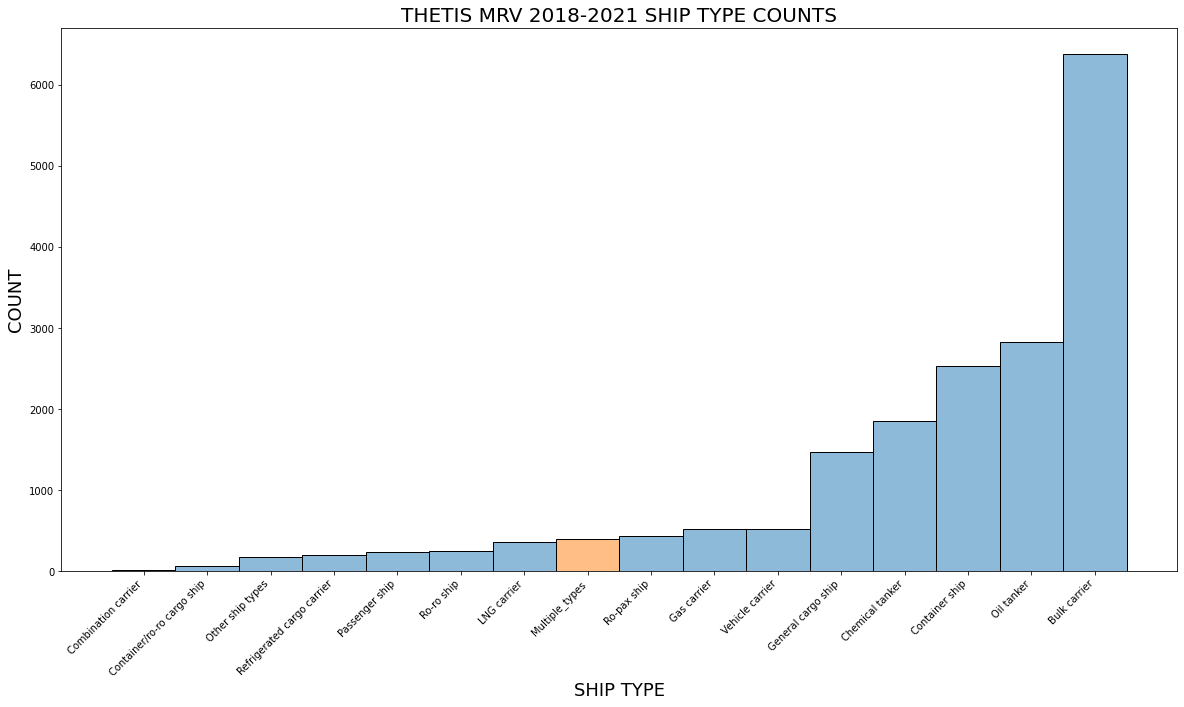

In [137]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=45, ha = "right")
plt.title("THETIS MRV 2018-2021 SHIP TYPE COUNTS", fontsize=20)
plt.xlabel("SHIP TYPE", fontsize=18)
plt.ylabel("COUNT", fontsize=18)
hue = [1 if stype == "Multiple_types" else 0 for stype in IMO_Type_df_byIMO.Ship_type.loc[idx_order]]
sns.histplot(data=IMO_Type_df_byIMO.loc[idx_order], x="Ship_type", hue=hue)
plt.legend([],[], frameon=False)

In [152]:
type_order_firstyr = mrv_df_list[0].Ship_type.value_counts()[::-1]
order_func = lambda x: type_order_firstyr.loc[x]
idx_order_firstyr = mrv_df_list[0].apply(order_func).sort_values().index

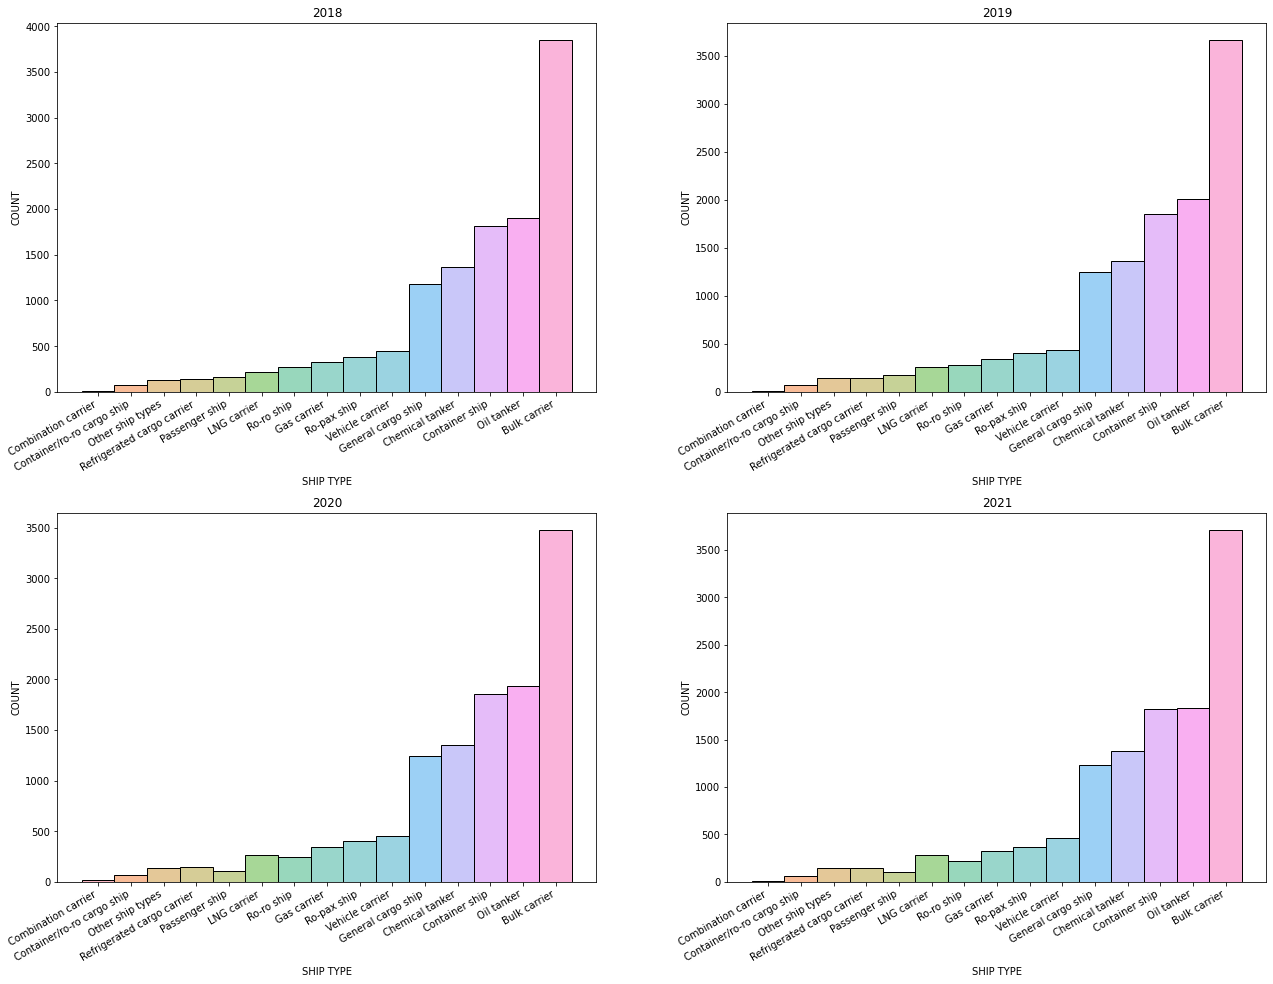

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.tight_layout(pad=10)
dfs = [mrv_df_list[:2],mrv_df_list[2:]]
colours =  [["blue","orange"],["green", "red"]]
for i in range(2):
    for j in range(2):
        ax = axs[i,j]
        df = dfs[i][j]
        idx_order = df.Ship_type.apply(order_func).sort_values().index
        col = colours[i][j]
        ax.set_title(df.name)
        ax.set_xticklabels(labels = df.loc[idx_order].Ship_type.unique(), rotation=30, ha="right")
        ax.set_xlabel("SHIP TYPE")
        ax.set_ylabel("COUNT")
        sns.histplot(data=df.loc[idx_order], x="Ship_type", ax=ax, color=col, hue="Ship_type")
        ax.legend([],[], frameon=False)


In [172]:
Ship_type_counts = []
for df in mrv_df_list:
    Ship_type_counts.append(df.Ship_type.value_counts())

Ship_type_change_dict = {}
for i in range(len(Ship_type_counts[1:])):
    Ship_type_change_dict[f"{keys[i]}-{keys[i+1]}"] = (Ship_type_counts[i+1] 
                            - Ship_type_counts[i])/Ship_type_counts[i]*100
Ship_type_change_list = [Ship_type_change_dict[key] for key in sorted(Ship_type_change_dict.keys())]

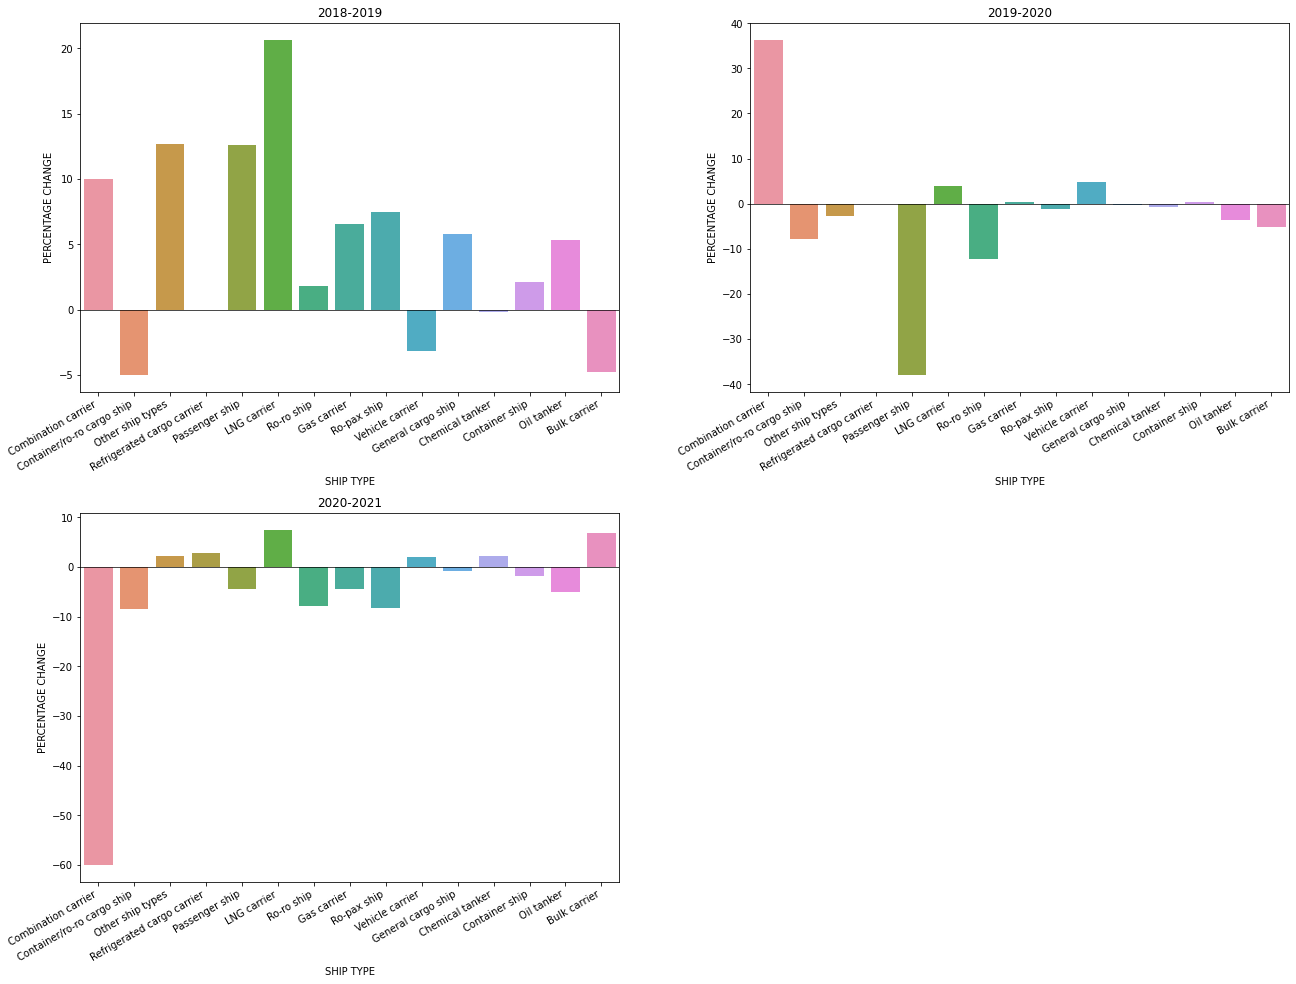

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
fig.tight_layout(pad=10)

for x in range(len(Ship_type_change_list)):
    i,j = x//2,x%2
    ax = axs[i,j]
    s = Ship_type_change_list[x].loc[type_order_firstyr.index]
    ax.set_xticklabels(labels=type_order_firstyr.index, rotation=30, ha="right")
    ax.set_xlabel("SHIP TYPE")
    ax.set_ylabel("PERCENTAGE CHANGE")
    ax.set_title(sorted(Ship_type_change_dict.keys())[x])
    sns.barplot(x=s.index, y=s.values, ax=ax)
    ax.legend([],[], frameon=False)
    ax.axhline(y=0, color='k', lw=0.7)
fig.delaxes(axs[1,1])

## EMISSION PROFILES

In [211]:
IMO_Type_df = mrv_df[["IMO_Number","Ship_type"]].copy().drop_duplicates()
IMO_Type_df 

IMO_Number         Ship_type
0         6703343  Other ship types
1         7037806       Ro-pax ship
2         7043843        Ro-ro ship
3         7128332       Ro-pax ship
4         7226952        Ro-ro ship
...           ...               ...
48749     9817561      Bulk carrier
48756     9819882       Gas carrier
48767     9823625  Other ship types
48791     9830161      Bulk carrier
48795     9835068      Bulk carrier

[18662 rows x 2 columns]

In [212]:
mrv_efficiency_df = mrv_df[["IMO_Number","Ship_type","Technical_efficiency", "Annual_average_CO₂_emissions_per_transport_work_(mass)_[g_CO₂_/_m_tonnes_·_n_miles]"]].copy()
mrv_efficiency_df.columns = ["IMO_Number", "Ship_type", "Technical_efficiency", "Measured_efficiency"]
mrv_efficiency_df

IMO_Number         Ship_type    Technical_efficiency  \
0         6703343  Other ship types   EIV (57.84 gCO₂/t·nm)   
1         7037806       Ro-pax ship    EIV (19.4 gCO₂/t·nm)   
2         7043843        Ro-ro ship   EIV (48.71 gCO₂/t·nm)   
3         7128332       Ro-pax ship    EIV (9.29 gCO₂/t·nm)   
4         7226952        Ro-ro ship      EIV (43 gCO₂/t·nm)   
...           ...               ...                     ...   
48798     9838199   Chemical tanker  EEDI (12.93 gCO₂/t·nm)   
48799     9839064      Bulk carrier                     NaN   
48800     9840790      Bulk carrier                     NaN   
48801     9847140   Chemical tanker    EIV (9.16 gCO₂/t·nm)   
48802     9848467        Ro-ro ship   EEDI (12.3 gCO₂/t·nm)   

      Measured_efficiency  
0                  210.74  
1                     NaN  
2                  695.22  
3                     NaN  
4                  250.63  
...                   ...  
48798               56.31  
48799   Division by zero!  
48800   Division by zero!  
48801               13.33  
48802              273.55  

[48803 rows x 4 columns]

In [304]:
def handle_te_type(te):
    try:
        te_type = re.findall(r"(EIV|EEDI)",te)[0]
        return te_type
    except: 
        return np.nan

def handle_te_val(te):
    try:
        te_value = float(re.findall(r"(\(\d.*\s)",te)[0][1:-1])
        if te_value == 0:
            return np.nan
        return te_value
    except: 
        return np.nan
def handle_emispt(emis):
    if type(emis) == float:
        return emis
    else:
        return np.nan

In [214]:
mrv_efficiency_df.Technical_efficiency.isna().sum()

1697

In [215]:
mrv_efficiency_df["Technical_efficiency_measure"] = mrv_efficiency_df.Technical_efficiency.apply(handle_te_type)
mrv_efficiency_df.Technical_efficiency = mrv_efficiency_df.Technical_efficiency.apply(handle_te_val)
mrv_efficiency_df.Measured_efficiency = mrv_efficiency_df.Measured_efficiency.apply(handle_emispt)
mrv_efficiency_df

IMO_Number         Ship_type  Technical_efficiency  \
0         6703343  Other ship types                 57.84   
1         7037806       Ro-pax ship                 19.40   
2         7043843        Ro-ro ship                 48.71   
3         7128332       Ro-pax ship                  9.29   
4         7226952        Ro-ro ship                 43.00   
...           ...               ...                   ...   
48798     9838199   Chemical tanker                 12.93   
48799     9839064      Bulk carrier                   NaN   
48800     9840790      Bulk carrier                   NaN   
48801     9847140   Chemical tanker                  9.16   
48802     9848467        Ro-ro ship                 12.30   

       Measured_efficiency Technical_efficiency_measure  
0                   210.74                          EIV  
1                      NaN                          EIV  
2                   695.22                          EIV  
3                      NaN                          EIV  
4                   250.63                          EIV  
...                    ...                          ...  
48798                56.31                         EEDI  
48799                  NaN                          NaN  
48800                  NaN                          NaN  
48801                13.33                          EIV  
48802               273.55                         EEDI  

[48803 rows x 5 columns]

In [ ]:
(mrv_efficiency_df.Technical_efficiency > 150).sum()

58

Text(0.5, 0, 'TE (gCO2 per t.nm)')

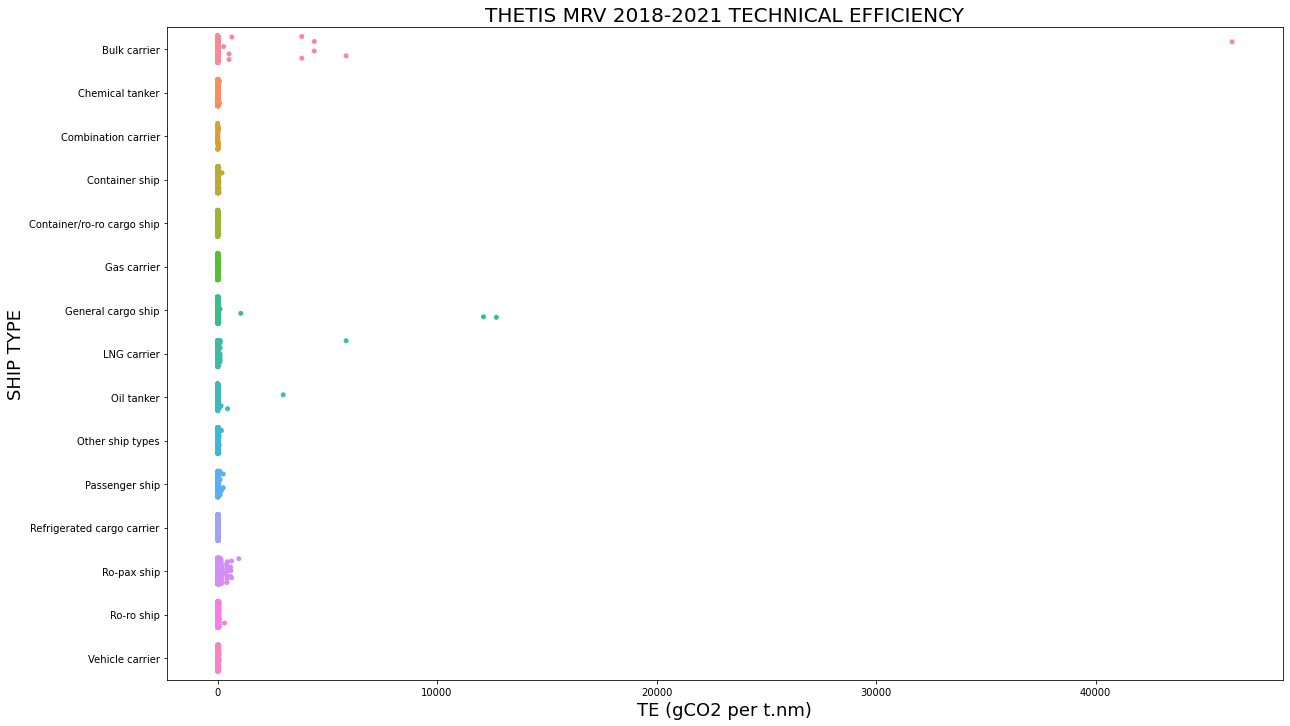

In [216]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY", fontsize=20)
sns.stripplot(data = mrv_efficiency_df.sort_values("Ship_type"), x="Technical_efficiency", y="Ship_type", jitter=0.3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)

Text(0.5, 0, 'TE (gCO2 per t.nm)')

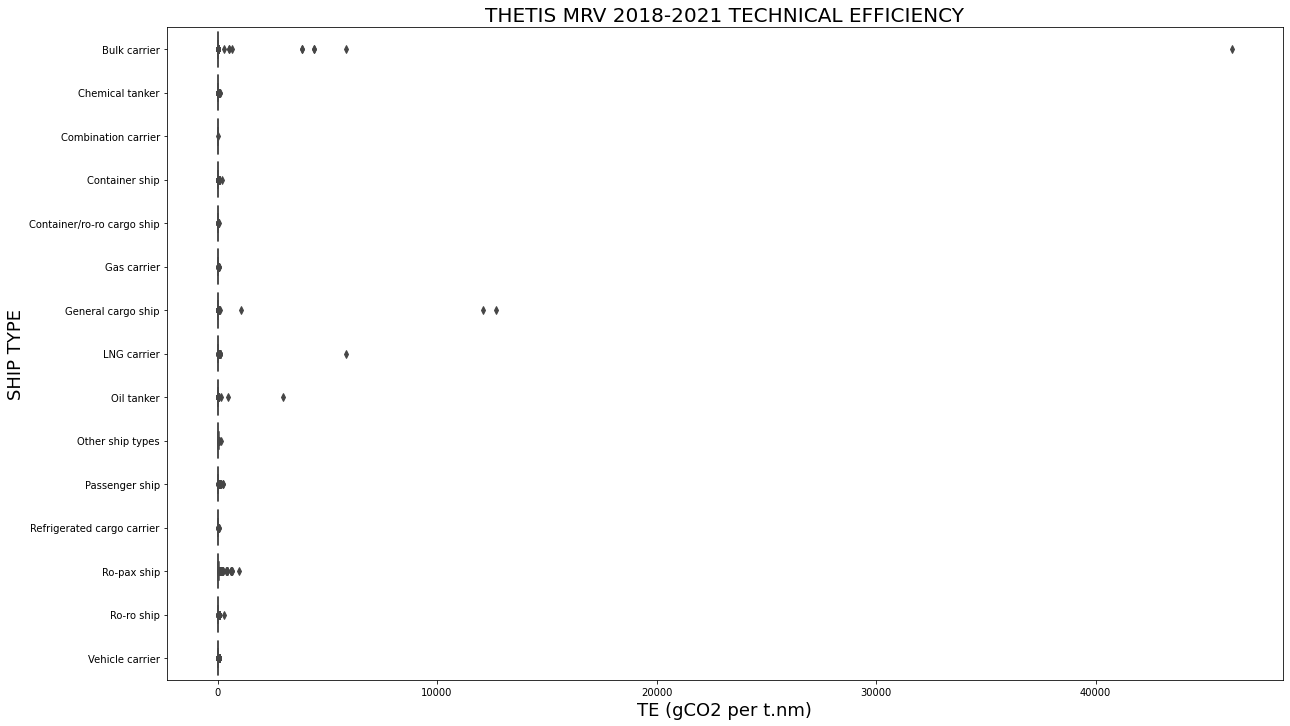

In [222]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY", fontsize=20)
sns.boxplot(data = mrv_efficiency_df.sort_values("Ship_type"), x="Technical_efficiency", y="Ship_type")
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)

In [217]:
mrv_efficiency_sub200_df = mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency < 200]
mrv_efficiency_sub50_df = mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency < 50]

Text(0.5, 0, 'TE (gCO2 per t.nm)')

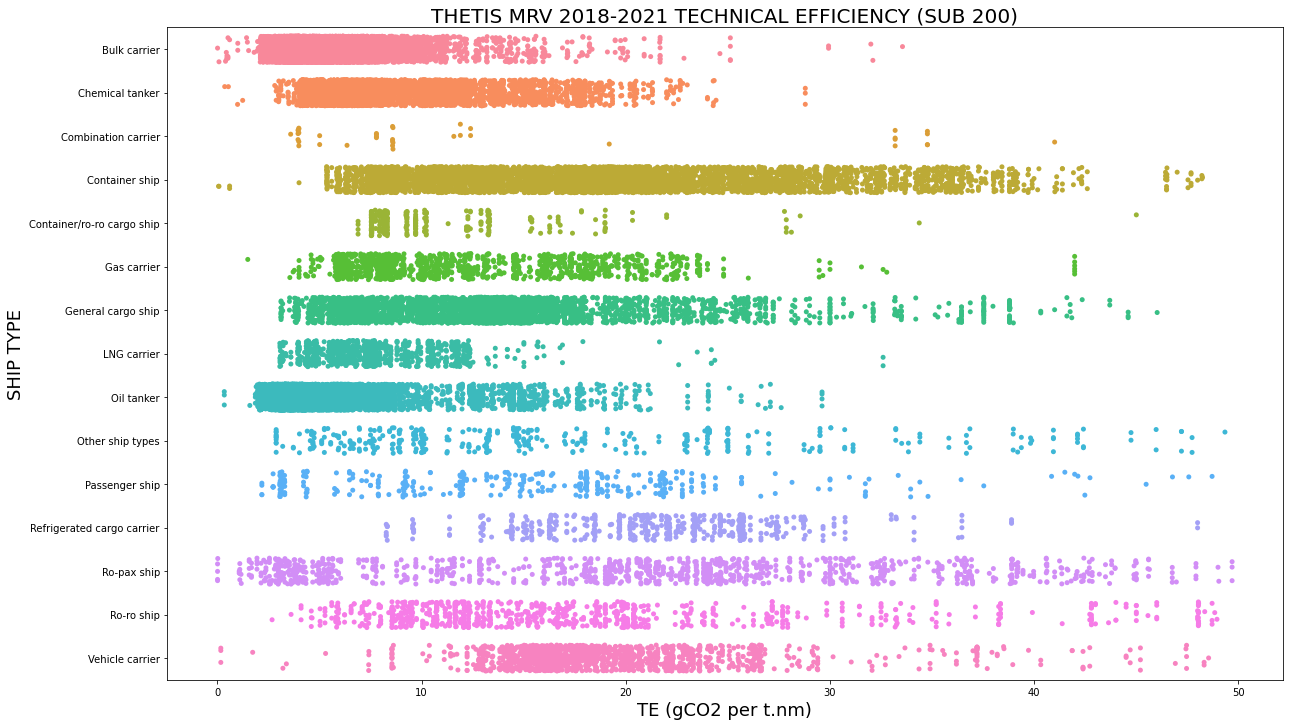

In [219]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY (SUB 200)", fontsize=20)
sns.stripplot(data = mrv_efficiency_sub50_df.sort_values("Ship_type"), x="Technical_efficiency", y="Ship_type", jitter=0.3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)

Text(0.5, 0, 'TE (gCO2 per t.nm)')

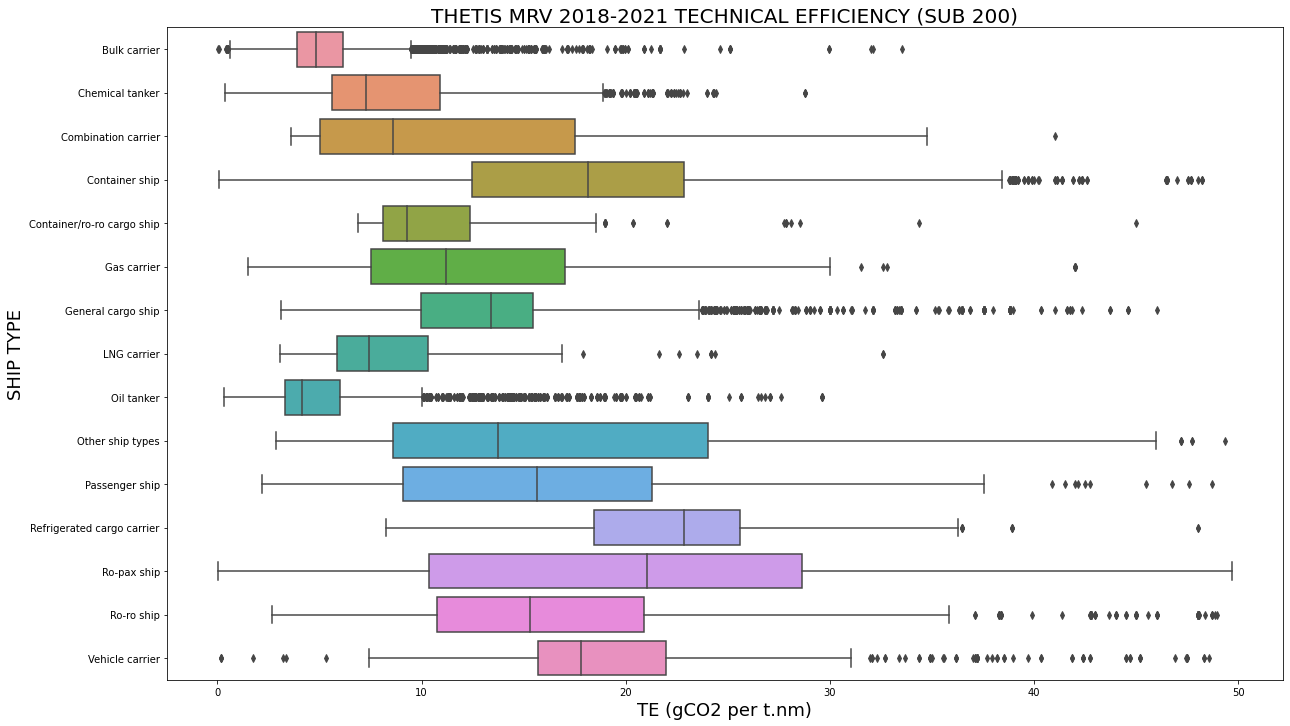

In [221]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY (SUB 200)", fontsize=20)
sns.boxplot(data = mrv_efficiency_sub50_df.sort_values("Ship_type"), x="Technical_efficiency", y="Ship_type")
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)

Text(0.5, 0, 'TE (gCO2 per t.nm)')

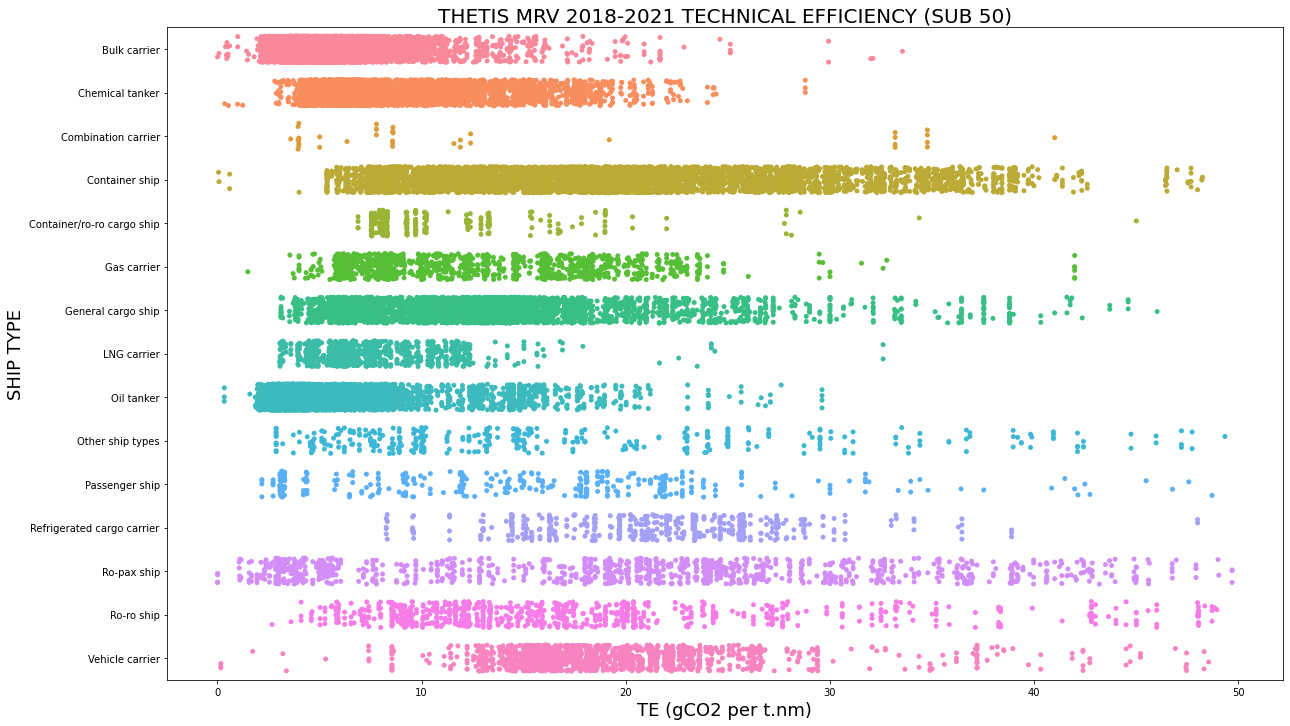

In [ ]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY (SUB 50)", fontsize=20)
sns.stripplot(data = mrv_efficiency_sub50_df.sort_values("Ship_type"), x="Technical_efficiency", y="Ship_type", jitter=0.3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)

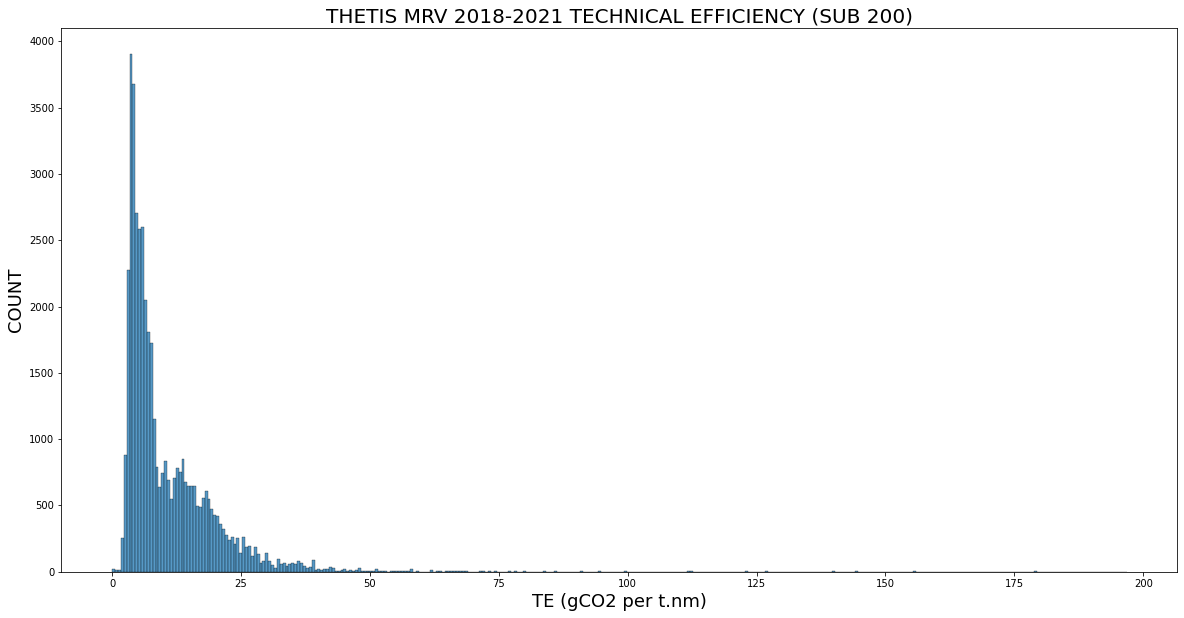

In [ ]:
plt.figure(figsize=(20,10))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY (SUB 200)", fontsize=20)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)
plt.ylabel("COUNT", fontsize=18)
sns.histplot(data = mrv_efficiency_sub200_df, x = "Technical_efficiency")

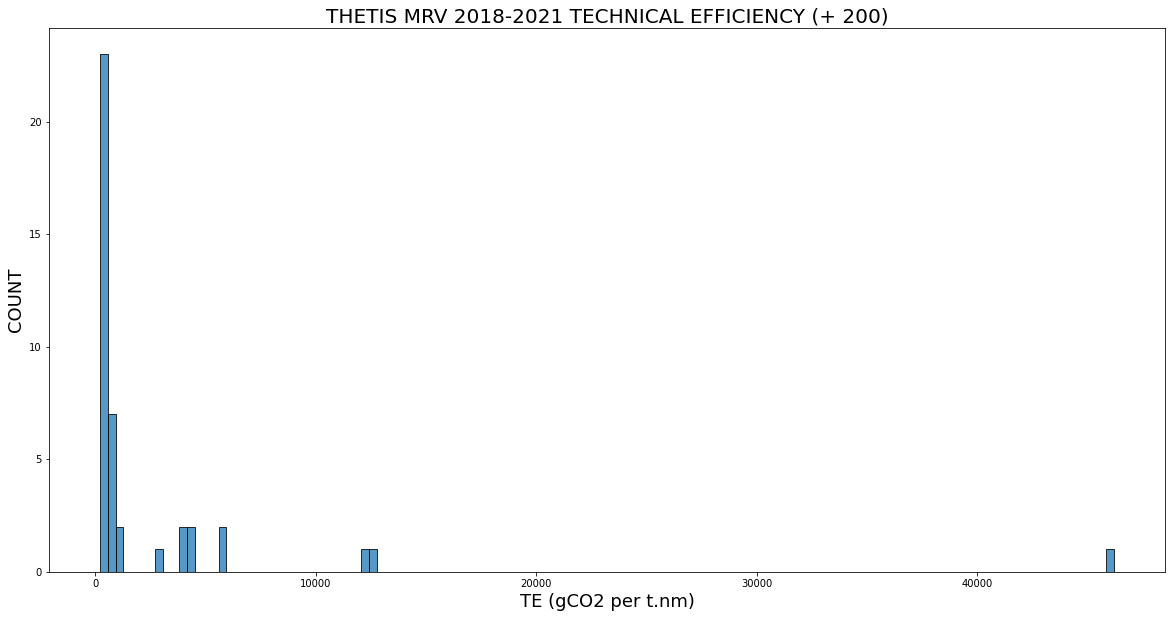

In [ ]:
plt.figure(figsize=(20,10))
plt.title("THETIS MRV 2018-2021 TECHNICAL EFFICIENCY (+ 200)", fontsize=20)
plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)
plt.ylabel("COUNT", fontsize=18)
sns.histplot(data = mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency > 200], x = "Technical_efficiency")

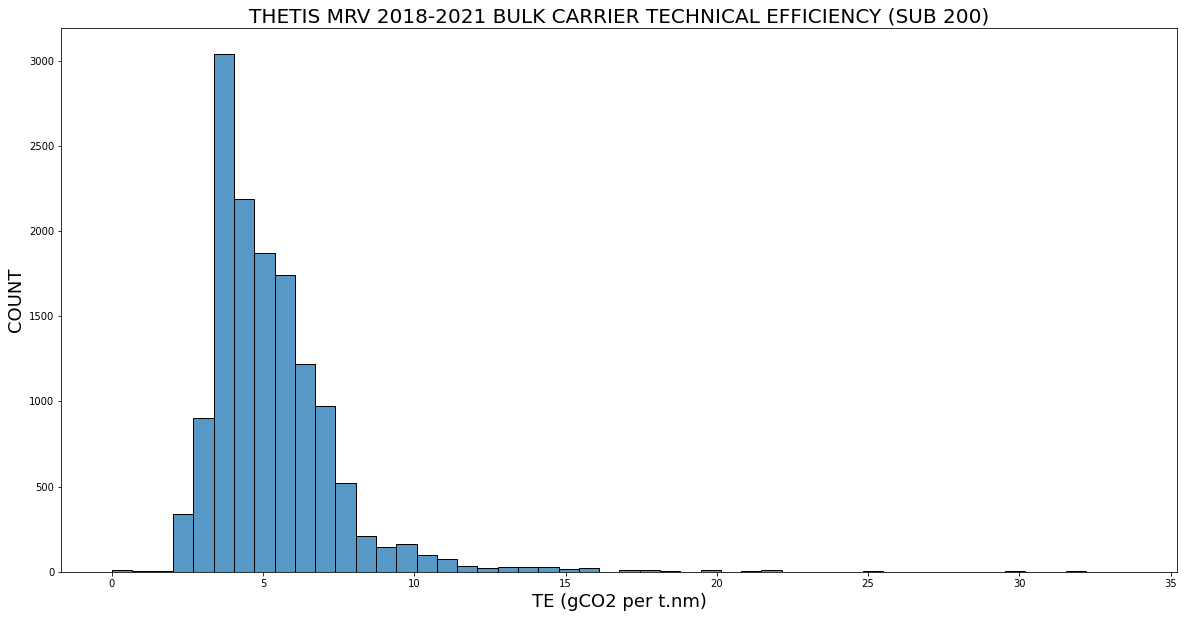

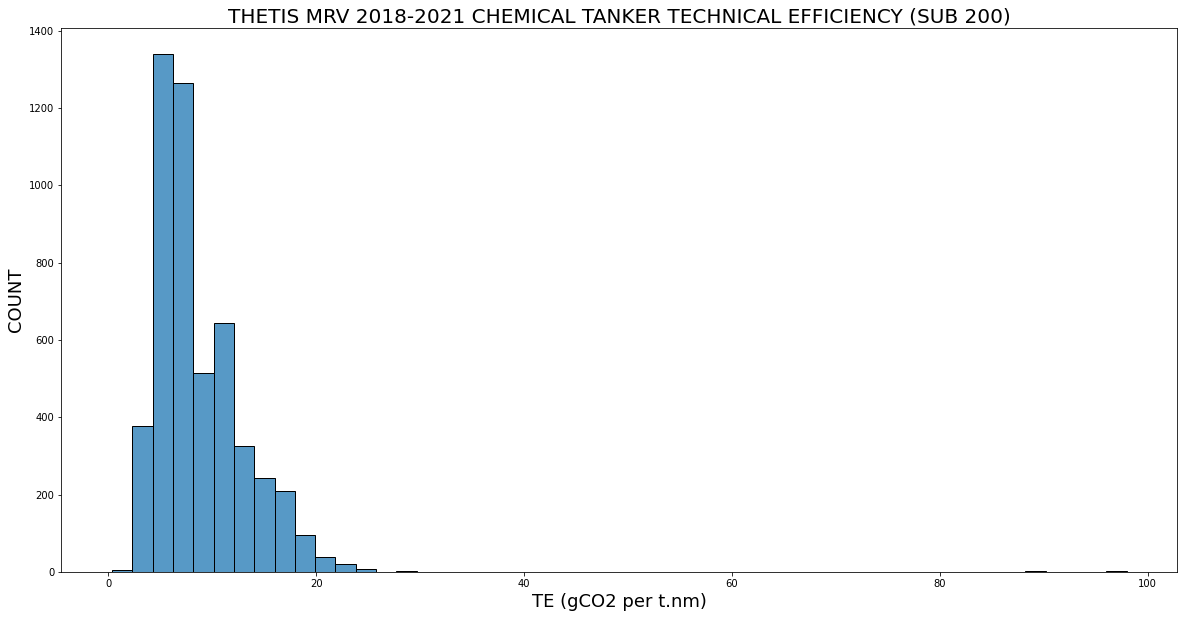

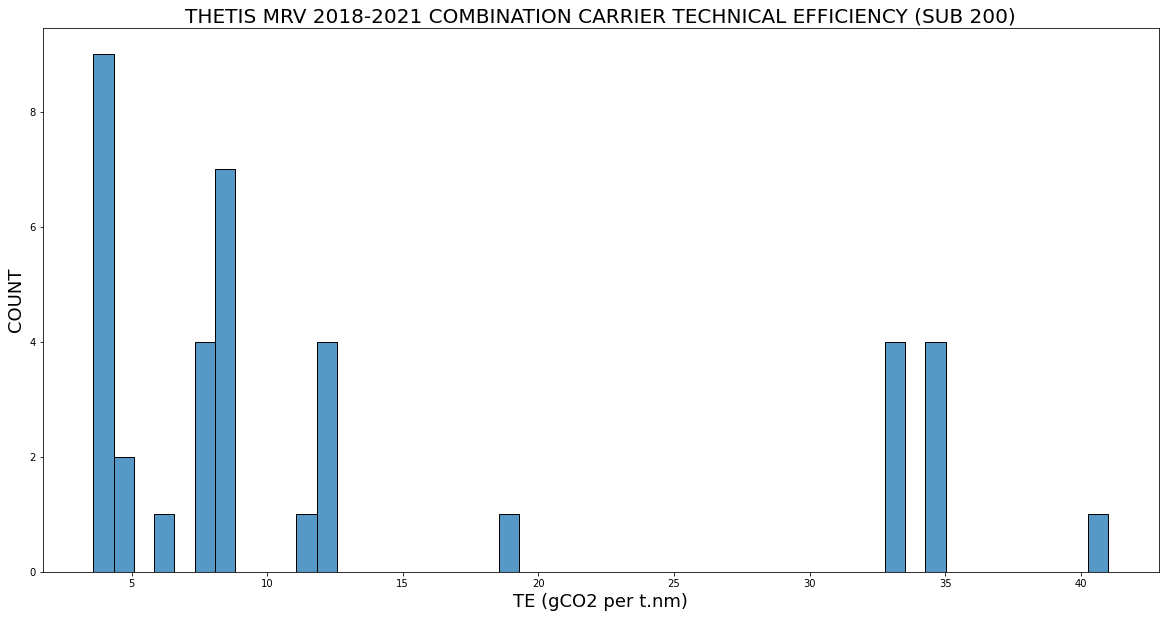

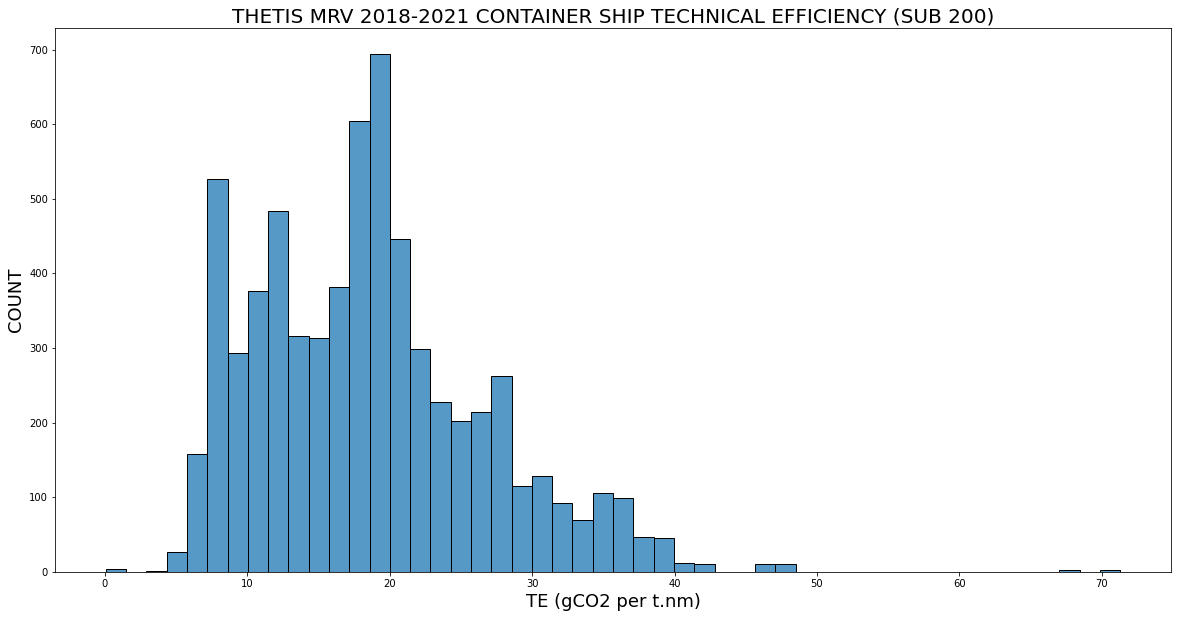

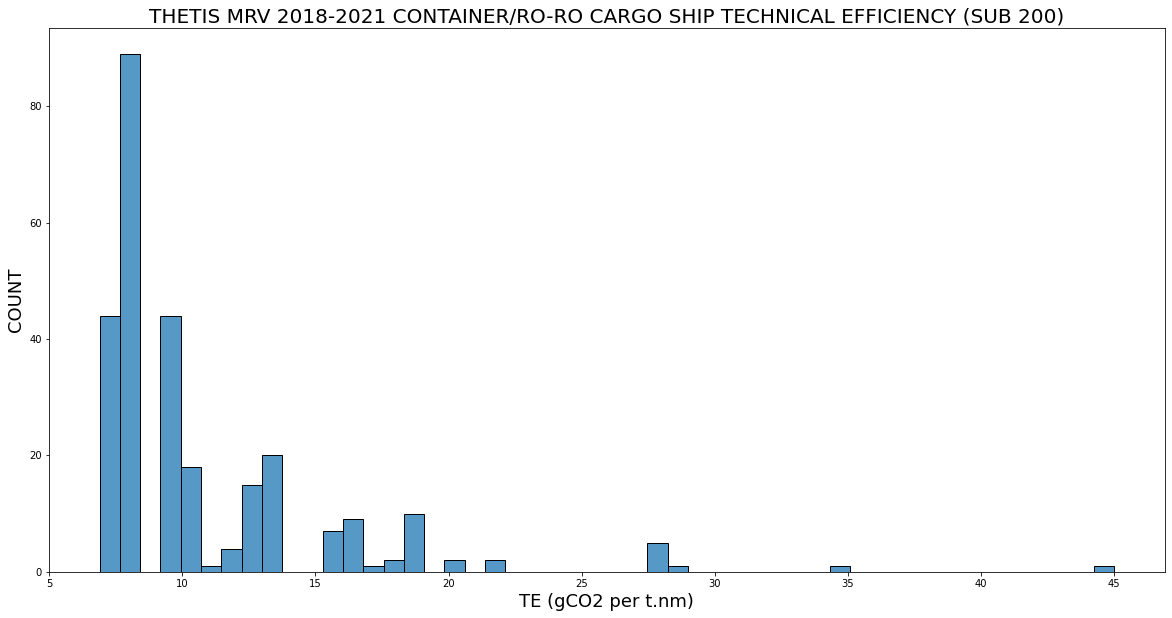

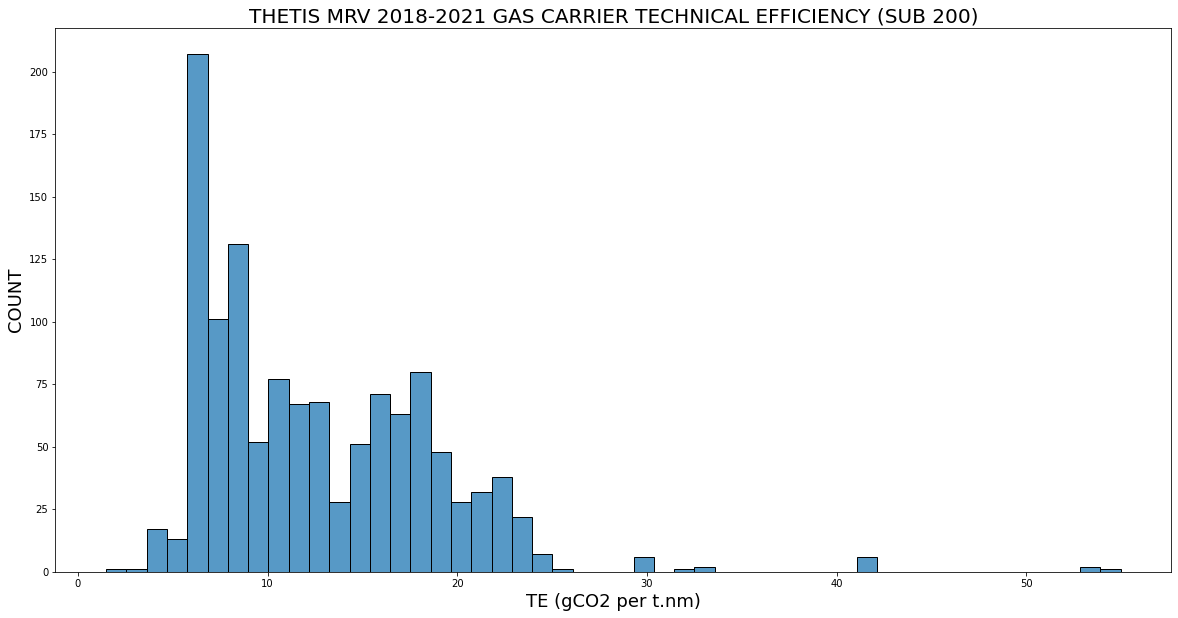

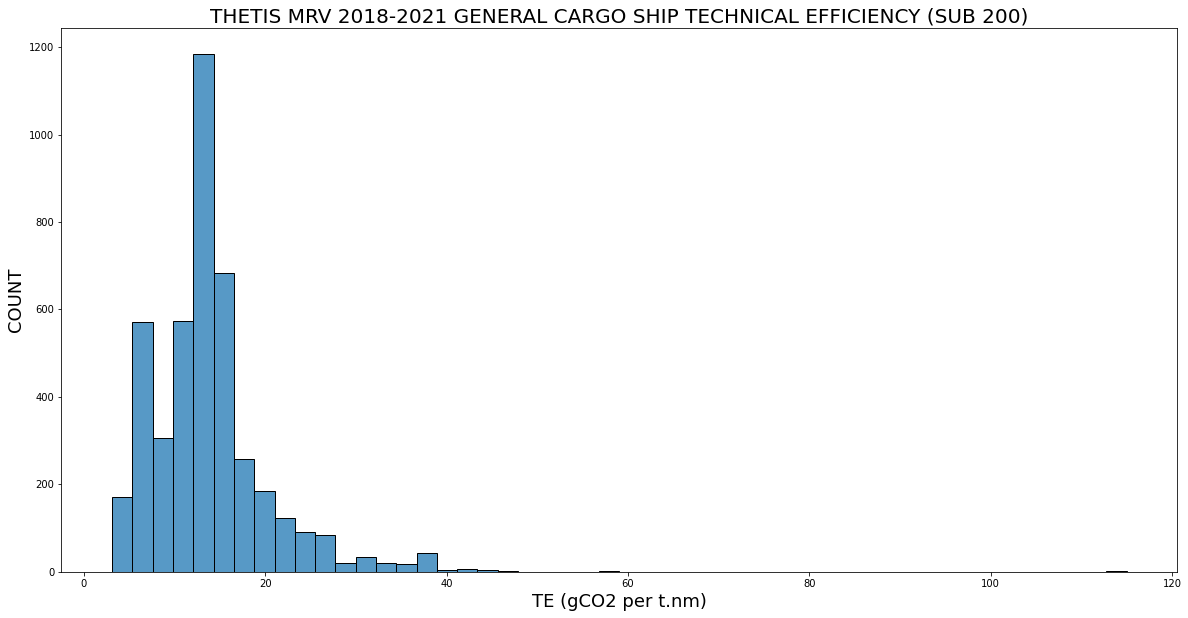

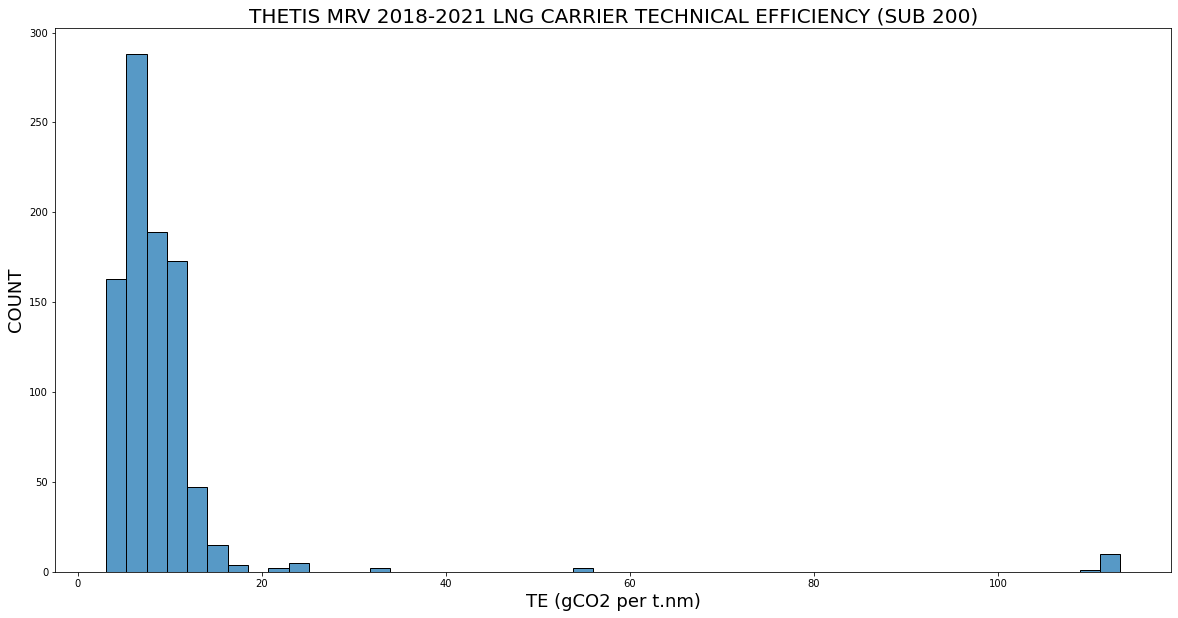

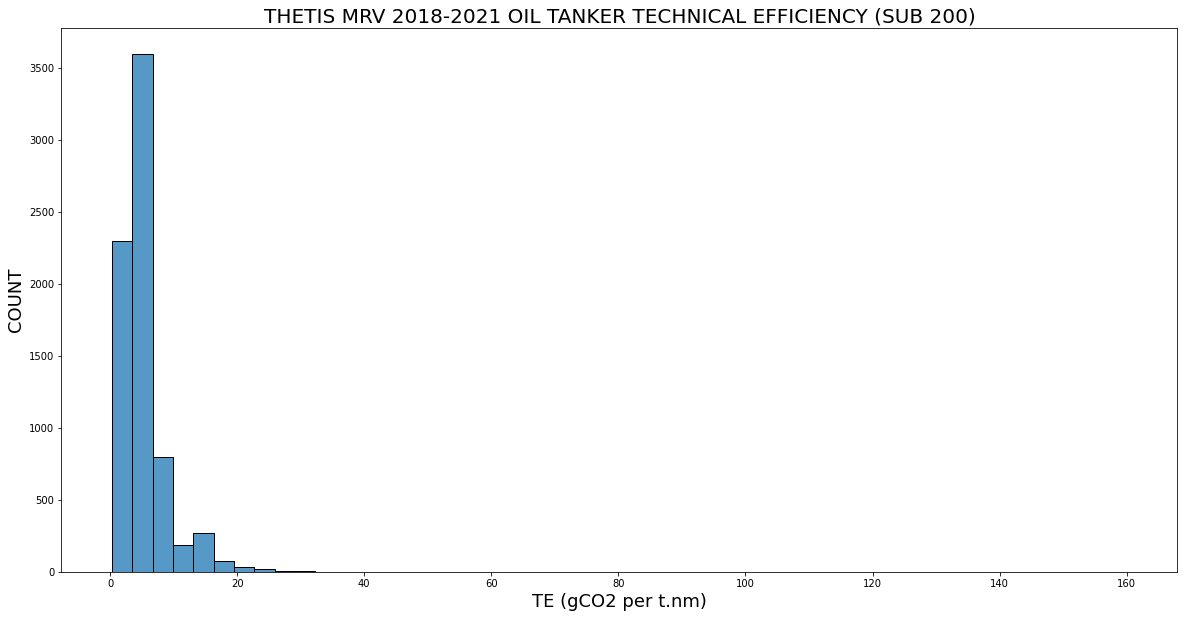

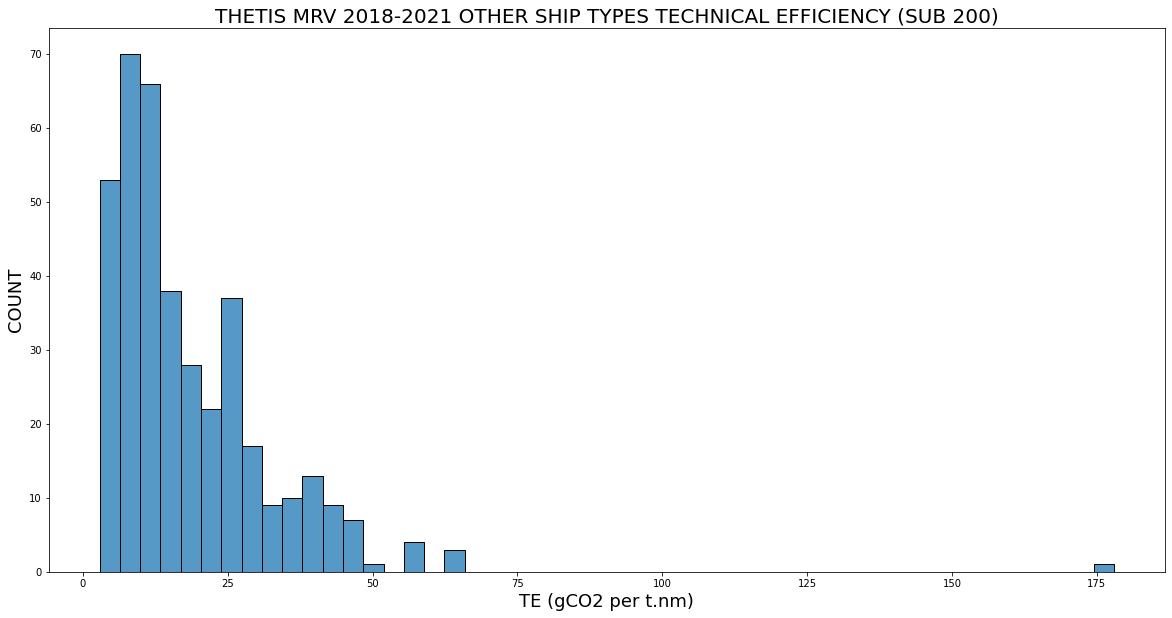

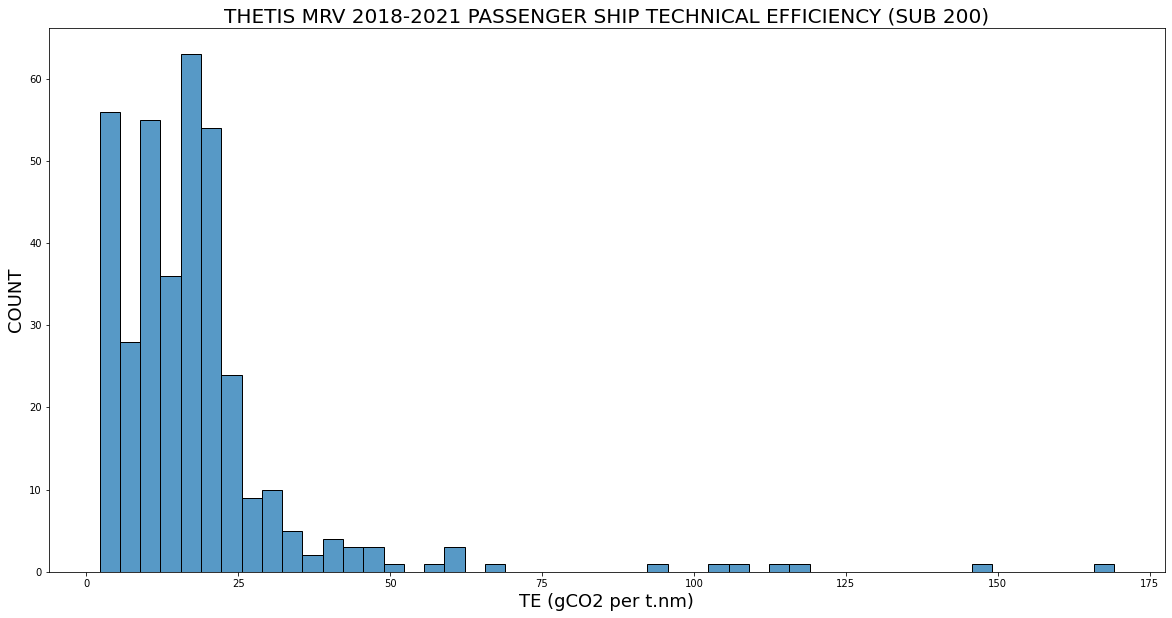

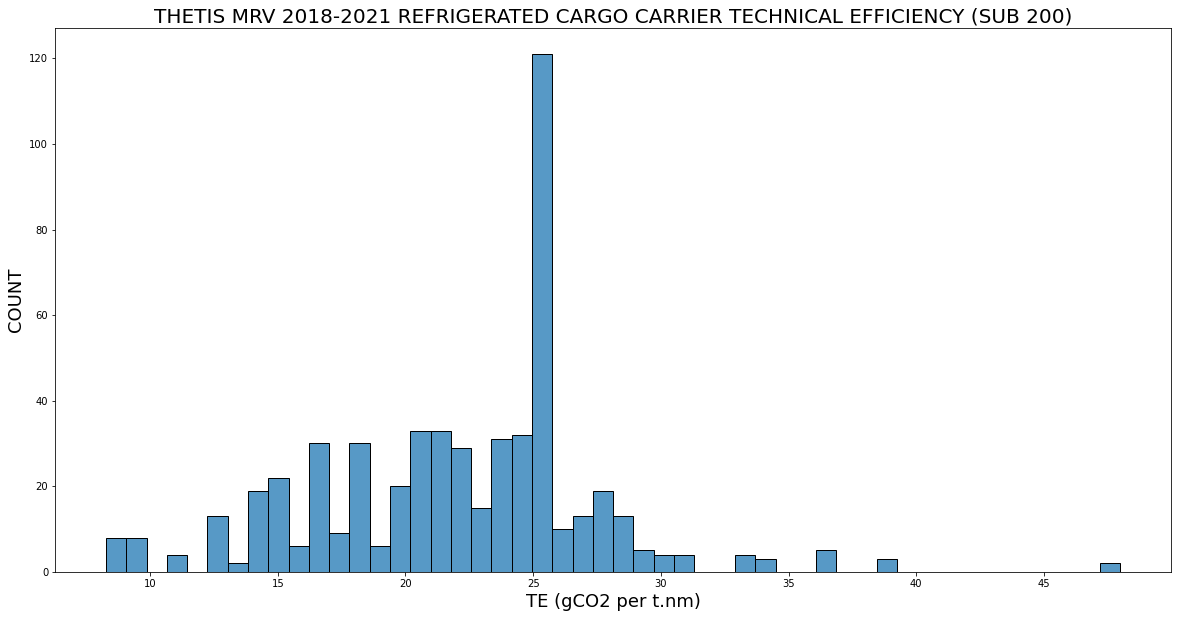

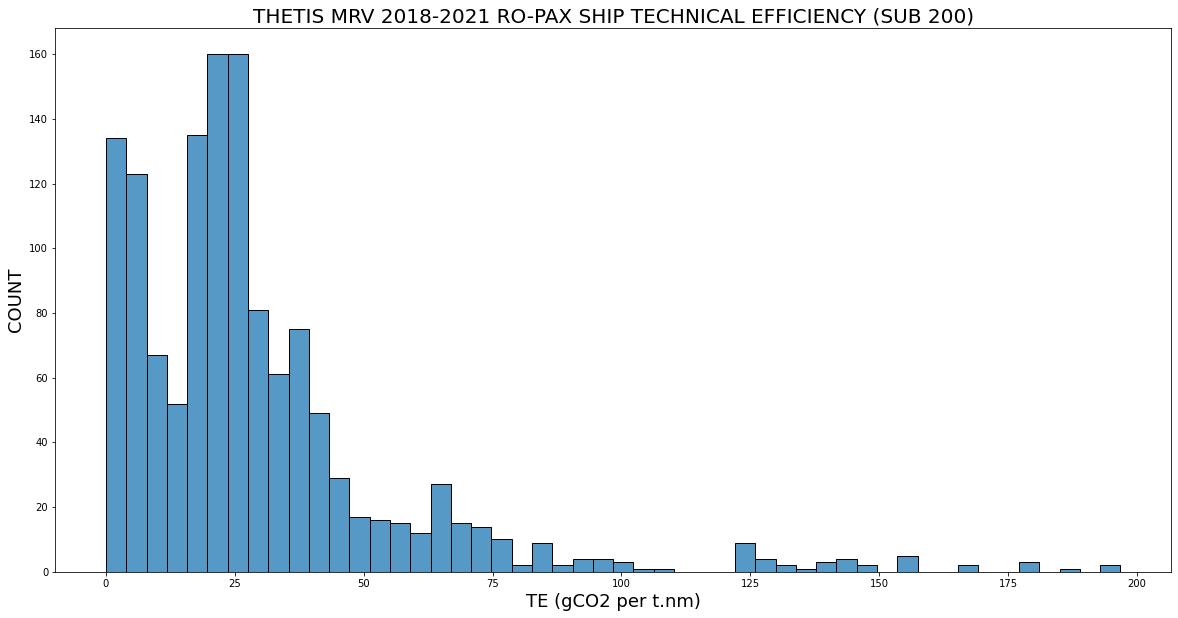

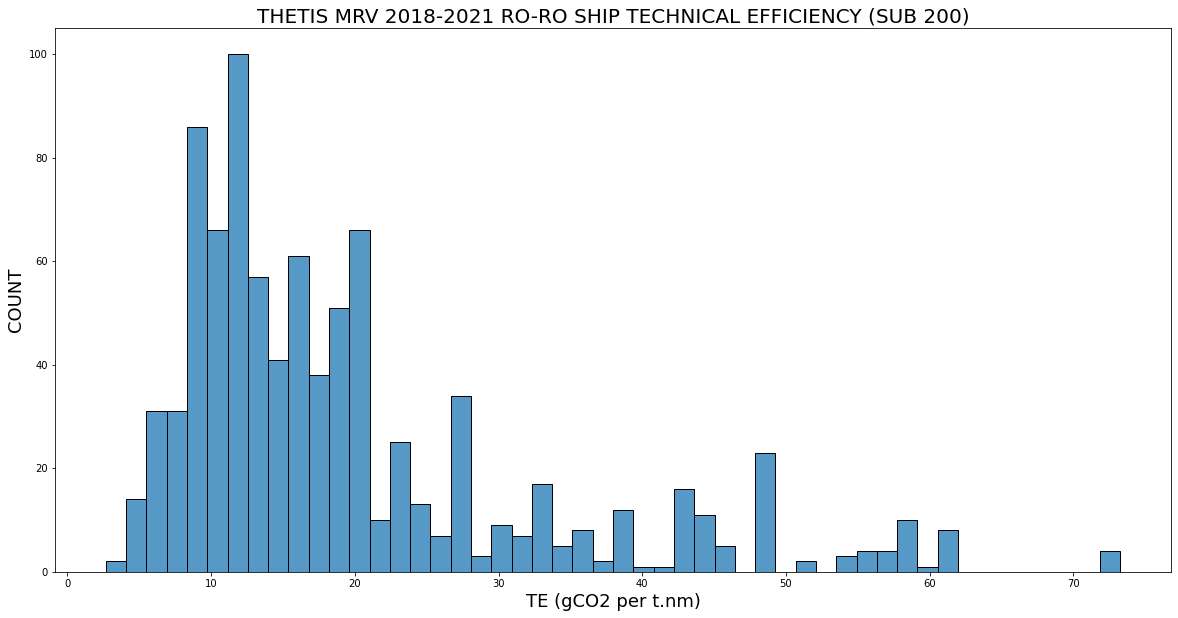

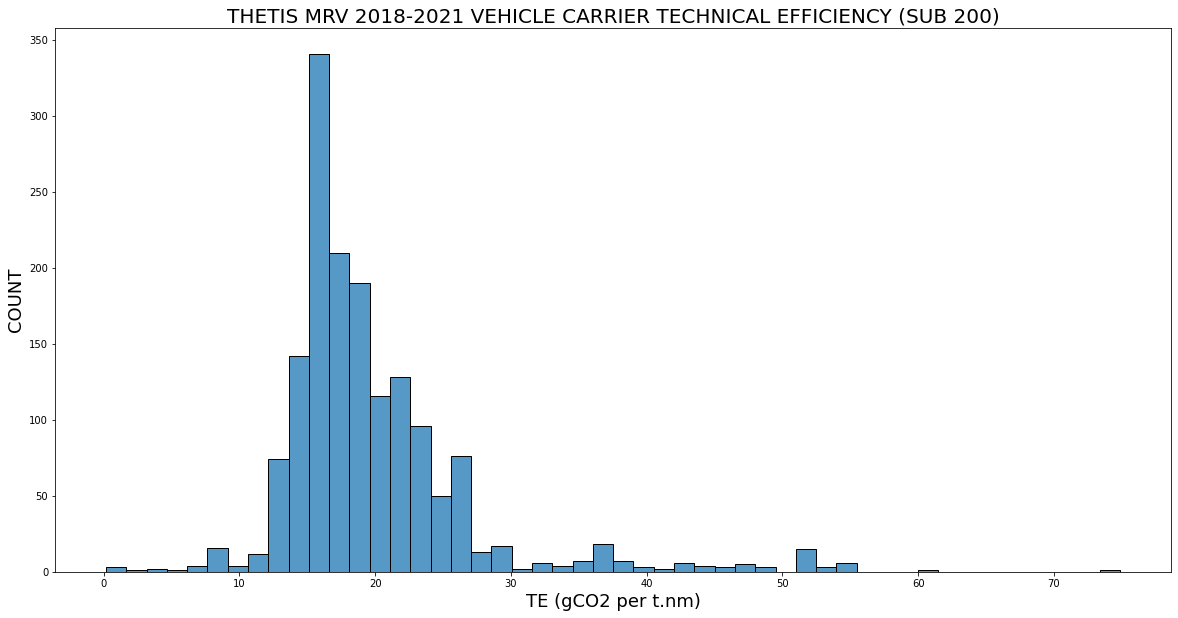

In [ ]:
for stype in sorted(mrv_efficiency_sub200_df.Ship_type.unique()):

    plt.figure(figsize=(20,10))
    plt.title(f"THETIS MRV 2018-2021 {stype.upper()} TECHNICAL EFFICIENCY (SUB 200)", fontsize=20)
    plt.xlabel("TE (gCO2 per t.nm)", fontsize=18)
    plt.ylabel("COUNT", fontsize=18)
    sns.histplot(data = mrv_efficiency_sub200_df[mrv_efficiency_sub200_df.Ship_type == stype],
                 x = "Technical_efficiency", bins = 50)

Text(0.5, 0, 'TE (gCO2 per t.nm)')

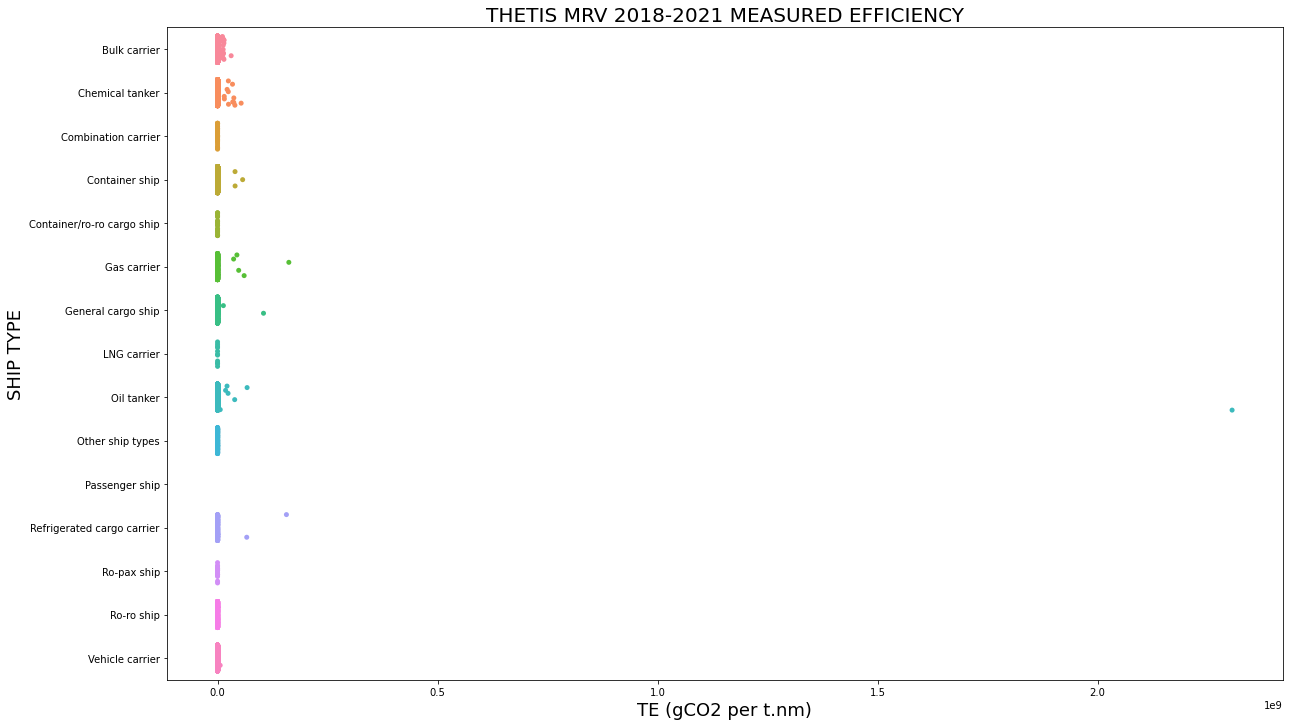

In [ ]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 MEASURED EFFICIENCY", fontsize=20)
sns.stripplot(data = mrv_efficiency_df.sort_values("Ship_type"), x="Measured_efficiency", y="Ship_type", jitter=0.3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("ME (gCO2 per t.nm)", fontsize=18)

In [ ]:
(mrv_efficiency_df.Measured_efficiency > 200).sum()

39228

In [224]:
mrv_efficiency_sub200me_df = mrv_efficiency_df[mrv_efficiency_df.Measured_efficiency < 200]
mrv_efficiency_sub50me_df = mrv_efficiency_df[mrv_efficiency_df.Measured_efficiency < 50]

Text(0.5, 0, 'ME (gCO2 per t.nm)')

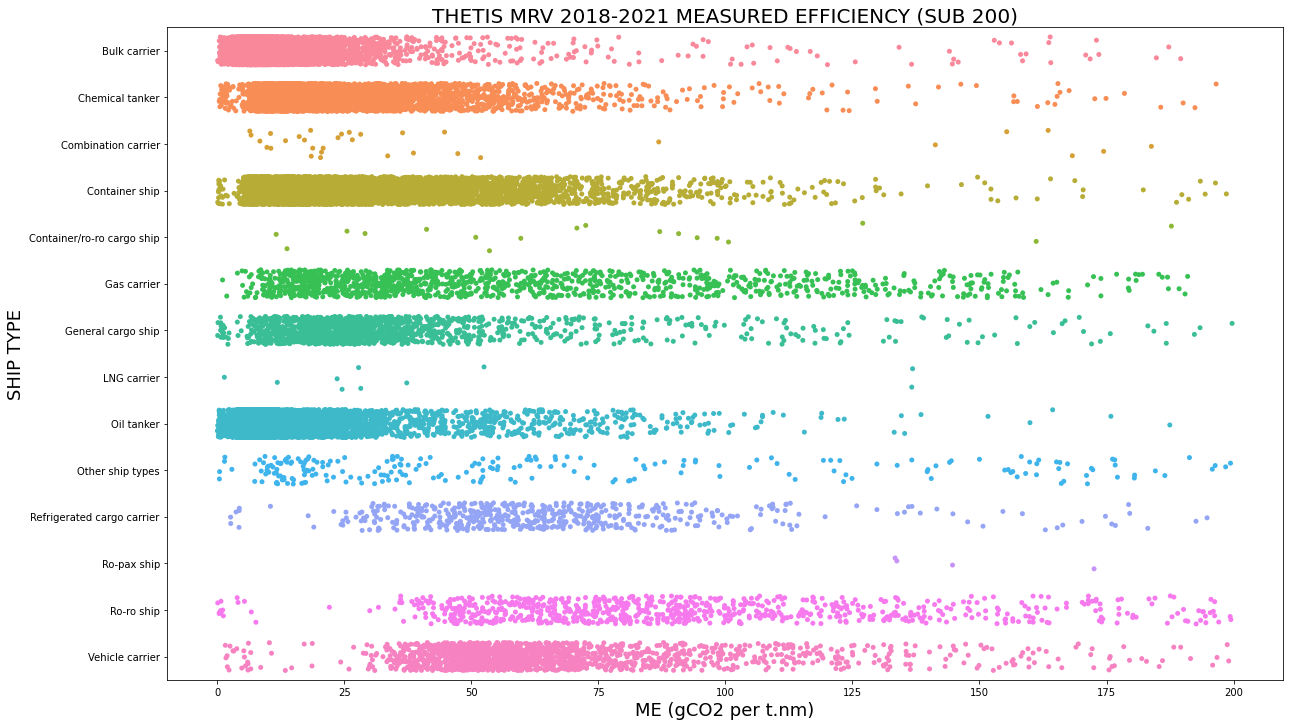

In [226]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 MEASURED EFFICIENCY (SUB 200)", fontsize=20)
sns.stripplot(data = mrv_efficiency_sub200me_df.sort_values("Ship_type"), x="Measured_efficiency", y="Ship_type", jitter=0.3)
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("ME (gCO2 per t.nm)", fontsize=18)

Text(0.5, 0, 'ME (gCO2 per t.nm)')

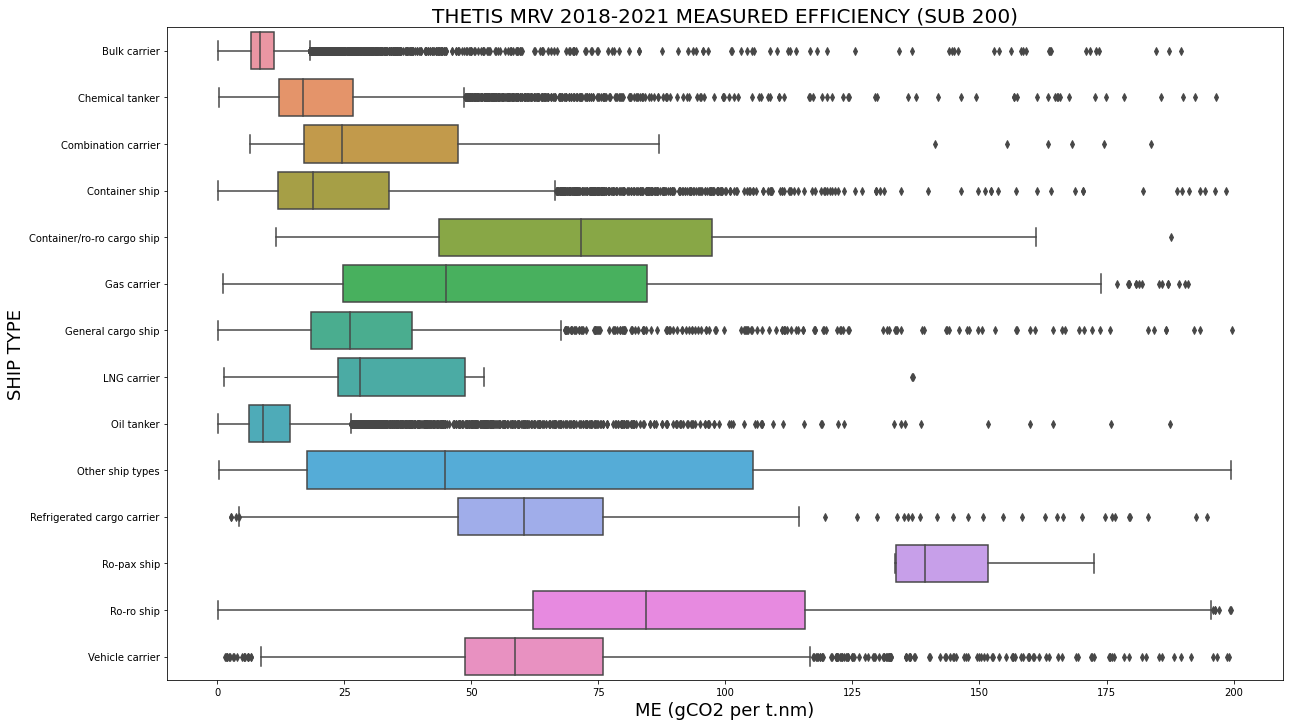

In [225]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 MEASURED EFFICIENCY (SUB 200)", fontsize=20)
sns.boxplot(data = mrv_efficiency_sub200me_df.sort_values("Ship_type"), x="Measured_efficiency", y="Ship_type")
plt.ylabel("SHIP TYPE", fontsize=18)
plt.xlabel("ME (gCO2 per t.nm)", fontsize=18)

In [ ]:
mrv_efficiency_me_indexes = mrv_efficiency_df[mrv_efficiency_df.Measured_efficiency < 300].index
mrv_efficiency_indexes = mrv_efficiency_df[mrv_efficiency_df.Technical_efficiency < 50].index
index_intersection = np.intersect1d(mrv_efficiency_me_indexes,mrv_efficiency_indexes)

Text(0.5, 0, 'ME (gCO2 per t.nm)')

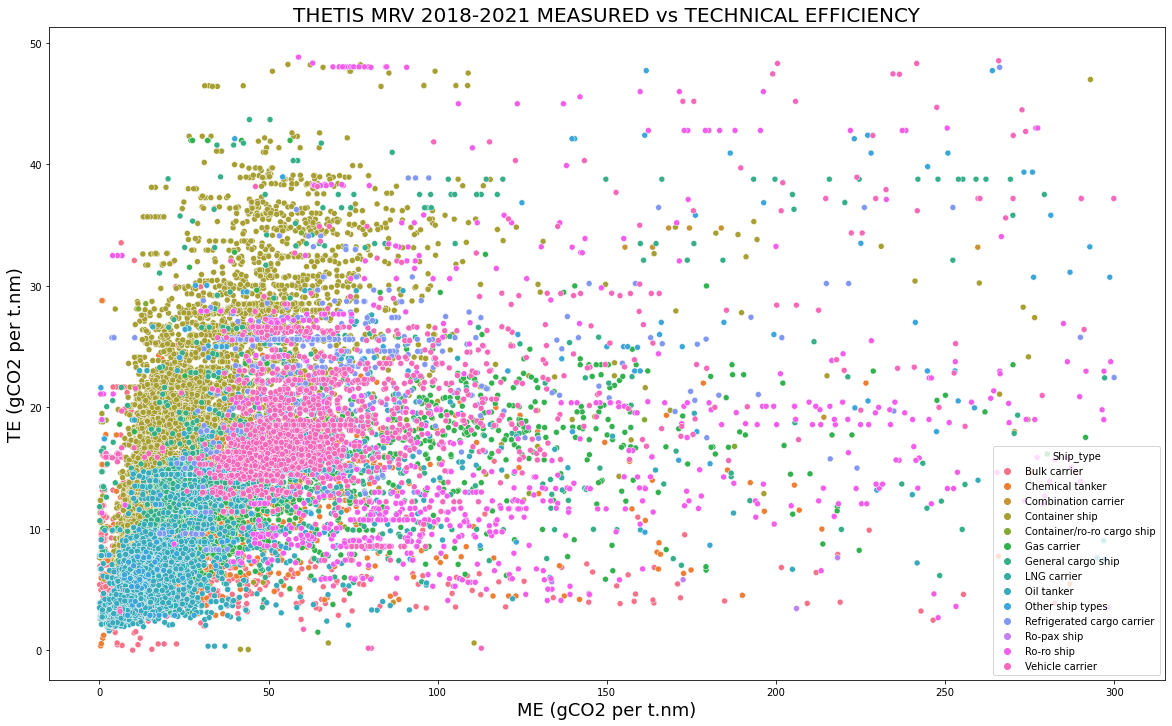

In [ ]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 MEASURED vs TECHNICAL EFFICIENCY", fontsize=20)
sns.scatterplot(data = mrv_efficiency_sub200_df.loc[index_intersection].sort_values("Ship_type"),
                 x="Measured_efficiency", y="Technical_efficiency", hue="Ship_type")
plt.ylabel("TE (gCO2 per t.nm)", fontsize=18)
plt.xlabel("ME (gCO2 per t.nm)", fontsize=18)

In [239]:
total_CO2_summed = mrv_df[["Ship_type","Total_CO₂_emissions_[m_tonnes]"]].groupby("Ship_type").sum().sort_values("Total_CO₂_emissions_[m_tonnes]", ascending=False)
total_CO2_summed

Total_CO₂_emissions_[m_tonnes]
Ship_type                                                 
Container ship                                1.723717e+08
Oil tanker                                    7.417306e+07
Bulk carrier                                  6.684244e+07
Ro-pax ship                                   5.427666e+07
Chemical tanker                               3.725996e+07
LNG carrier                                   2.852107e+07
General cargo ship                            2.558334e+07
Ro-ro ship                                    2.327929e+07
Vehicle carrier                               1.819246e+07
Passenger ship                                1.727008e+07
Gas carrier                                   1.075383e+07
Refrigerated cargo carrier                    6.446633e+06
Container/ro-ro cargo ship                    5.793125e+06
Other ship types                              4.290483e+06
Combination carrier                           3.857672e+05

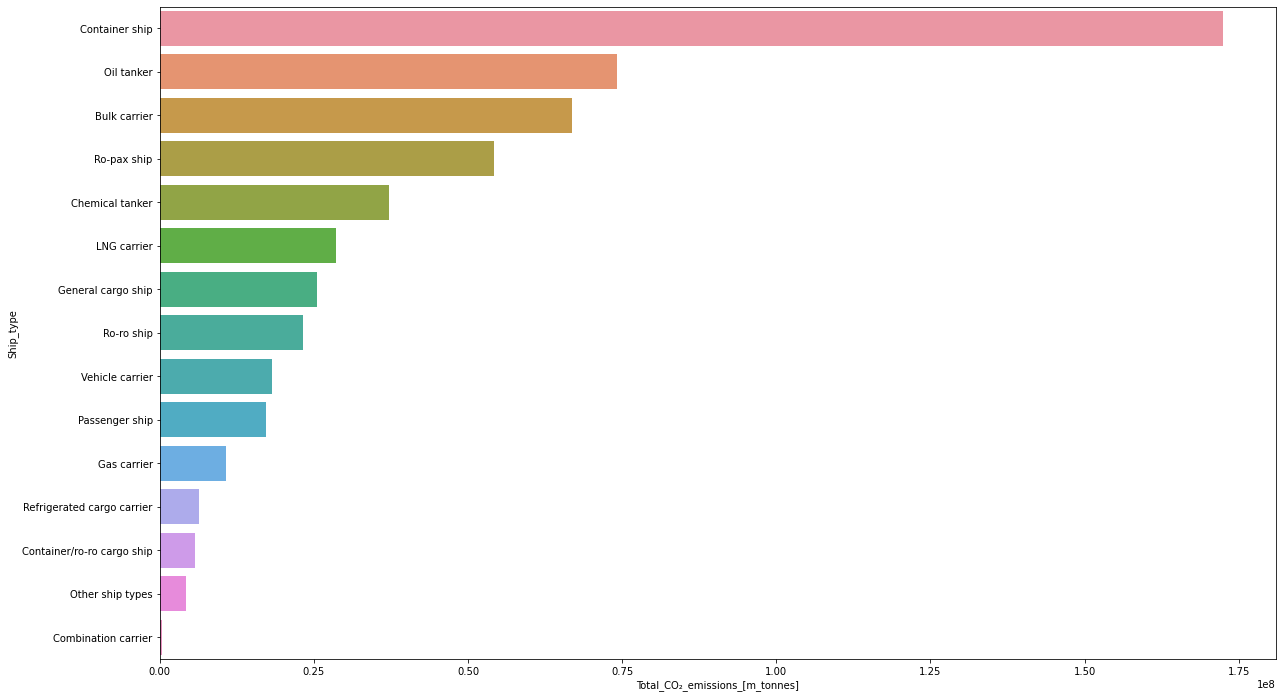

In [240]:
plt.figure(figsize=(20,12))
sns.barplot(x=total_CO2_summed["Total_CO₂_emissions_[m_tonnes]"], y = total_CO2_summed.index)

## Deadweight and Emission Intensity

In [233]:
mrv_df.columns

Index(['index', 'IMO_Number', 'Name', 'Ship_type', 'Reporting_Period',
       'Technical_efficiency', 'Port_of_Registry', 'Home_Port', 'Ice_Class',
       'DoC_issue_date', 'DoC_expiry_date', 'Verifier_Number', 'Verifier_Name',
       'Verifier_NAB', 'Verifier_Address', 'Verifier_City',
       'Verifier_Accreditation_number', 'Verifier_Country', 'A', 'B', 'C', 'D',
       'Total_fuel_consumption_[m_tonnes]',
       'Fuel_consumptions_assigned_to_On_laden_[m_tonnes]',
       'Total_CO₂_emissions_[m_tonnes]',
       'CO₂_emissions_from_all_voyages_between_ports_under_a_MS_jurisdiction_[m_tonnes]',
       'CO₂_emissions_from_all_voyages_which_departed_from_ports_under_a_MS_jurisdiction_[m_tonnes]',
       'CO₂_emissions_from_all_voyages_to_ports_under_a_MS_jurisdiction_[m_tonnes]',
       'CO₂_emissions_which_occurred_within_ports_under_a_MS_jurisdiction_at_berth_[m_tonnes]',
       'CO₂_emissions_assigned_to_Passenger_transport_[m_tonnes]',
       'CO₂_emissions_assigned_to_Freight_trans

In [328]:
cols = ["IMO_Number", "Ship_type", "Technical_efficiency",
        "Annual_average_CO₂_emissions_per_transport_work_(mass)_[g_CO₂_/_m_tonnes_·_n_miles]",
        "Total_fuel_consumption_[m_tonnes]", 
        "Annual_average_Fuel_consumption_per_distance_[kg_/_n_mile]",
        "Annual_average_Fuel_consumption_per_transport_work_(dwt)_[g_/_dwt_carried_·_n_miles]"]

renamed = ["IMO_Number", "Ship_type", "Technical_efficiency",
        "Measured_Efficiency",
        "Fuel_cons_t", 
        "Fuel_cons_per_dist_kg/nm",
        "Fuel_cons_per_dwt_dist_g/dwt.nm"]
mrv_dwt_df = mrv_df[cols].copy()
mrv_dwt_df.columns = renamed
mrv_dwt_df.Technical_efficiency = mrv_dwt_df.Technical_efficiency.apply(handle_te_val)
mrv_dwt_df.Measured_Efficiency = mrv_dwt_df.Measured_Efficiency.apply(handle_emispt)
mrv_dwt_df["Fuel_cons_per_dist_kg/nm"] = pd.to_numeric(mrv_dwt_df["Fuel_cons_per_dist_kg/nm"],errors="coerce")
mrv_dwt_df["Fuel_cons_per_dwt_dist_g/dwt.nm"] = pd.to_numeric(mrv_dwt_df["Fuel_cons_per_dwt_dist_g/dwt.nm"],errors="coerce")

mrv_dwt_df["DWT_Calculated"] = mrv_dwt_df["Fuel_cons_per_dist_kg/nm"]*1000/mrv_dwt_df["Fuel_cons_per_dwt_dist_g/dwt.nm"]

In [278]:
def get_dwt(IMO):
  
  base_url = 'https://www.vesselfinder.com/vessels?name='
  # set a header so avoid request errors
  headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) '\
           'AppleWebKit/537.36 (KHTML, like Gecko) '\
           'Chrome/75.0.3770.80 Safari/537.36'}
  # build url
  url = base_url+str(IMO)
  # downlaod page
  page = requests.get(url,headers = headers)
  # try to pull out the dwt
  try:
    dwt = int(page.text.split('<td class="v5 is-hidden-mobile">')[1].split('</td><td class="v6 is-hidden-mobile">')[0])
  except:
    dwt = -1
    print(f'Failed to get {IMO}')
  return {'IMO_Number' : IMO,
          'DWT' : int(dwt)}

In [284]:
with ThreadPool(40) as t:
  dwts = list(tqdm(t.imap(get_dwt,mrv_dwt_df.IMO_Number.unique()),total=mrv_dwt_df.IMO_Number.unique().shape[0]))

 61%|██████▏   | 11193/18259 [03:34<01:55, 61.05it/s]

Failed to get 9829394


100%|██████████| 18259/18259 [05:52<00:00, 51.87it/s]


In [290]:
dwts_df = pd.DataFrame(dwts)
dwts_df.to_csv(os.path.join(cwd,"dwts.csv"))

In [291]:
dwts_df

IMO_Number    DWT
0         6703343   2045
1         7037806   1968
2         7043843   2838
3         7128332   4000
4         7226952   2566
...           ...    ...
18254     9814026   1305
18255     9816567  37634
18256     9817561  82076
18257     9830161  38016
18258     9835068  81723

[18259 rows x 2 columns]

In [329]:
mrv_dwt_df = mrv_dwt_df.merge(dwts_df, on="IMO_Number")
mrv_dwt_df.rename(columns={"DWT":"DWT_Listed"}, inplace=True)
mrv_dwt_df

IMO_Number         Ship_type  Technical_efficiency  \
0         6703343  Other ship types                 57.84   
1         6703343  Other ship types                 57.84   
2         6703343  Other ship types                 57.84   
3         6703343  Other ship types                   NaN   
4         7037806       Ro-pax ship                 19.40   
...           ...               ...                   ...   
48798     9814026    Passenger ship                 20.40   
48799     9816567      Bulk carrier                  5.48   
48800     9817561      Bulk carrier                  3.34   
48801     9830161      Bulk carrier                  5.44   
48802     9835068      Bulk carrier                  3.68   

       Measured_Efficiency  Fuel_cons_t  Fuel_cons_per_dist_kg/nm  \
0                   210.74       373.50                     70.25   
1                   211.88       225.70                     40.75   
2                   333.51      1607.60                     56.58   
3                   286.30       549.00                     63.46   
4                      NaN      1902.00                     82.04   
...                    ...          ...                       ...   
48798                  NaN      1780.46                     77.13   
48799                 6.70       793.08                     69.52   
48800                 4.11      2041.94                     97.48   
48801                 6.52       722.92                     75.41   
48802                 4.74       719.70                     99.13   

       Fuel_cons_per_dwt_dist_g/dwt.nm  DWT_Calculated  DWT_Listed  
0                                34.46     2038.595473        2045  
1                                54.28      750.736920        2045  
2                                 0.32   176812.500000        2045  
3                                  NaN             NaN        2045  
4                                  NaN             NaN        1968  
...                                ...             ...         ...  
48798                              NaN             NaN        1305  
48799                              NaN             NaN       37634  
48800                              NaN             NaN       82076  
48801                              NaN             NaN       38016  
48802                              NaN             NaN       81723  

[48803 rows x 9 columns]

In [331]:
mrv_dwt_df[mrv_dwt_df.DWT_Calculated.notnull()]

IMO_Number           Ship_type  Technical_efficiency  \
0         6703343    Other ship types                 57.84   
1         6703343    Other ship types                 57.84   
2         6703343    Other ship types                 57.84   
24        7310507    Other ship types                 31.13   
25        7310507    Other ship types                 31.13   
...           ...                 ...                   ...   
48472     9614701  General cargo ship                   NaN   
48623     9702625  General cargo ship                  4.73   
48656     9717656  General cargo ship                  4.80   
48664     9720067  General cargo ship                  3.94   
48710     9734173  General cargo ship                  5.50   

       Measured_Efficiency  Fuel_cons_t  Fuel_cons_per_dist_kg/nm  \
0                   210.74       373.50                     70.25   
1                   211.88       225.70                     40.75   
2                   333.51      1607.60                     56.58   
24                  566.60       860.30                     52.60   
25                  286.95       992.10                     47.82   
...                    ...          ...                       ...   
48472                  NaN       878.45                     69.57   
48623                11.99      1072.00                     65.29   
48656                 7.05      1539.00                     72.65   
48664                 6.31      1202.00                     79.32   
48710                 8.09       593.10                     80.73   

       Fuel_cons_per_dwt_dist_g/dwt.nm  DWT_Calculated  DWT_Listed  
0                                34.46     2038.595473        2045  
1                                54.28      750.736920        2045  
2                                 0.32   176812.500000        2045  
24                               54.60      963.369963        5579  
25                               72.75      657.319588        5579  
...                                ...             ...         ...  
48472                             8.46     8223.404255       17577  
48623                             2.26    28889.380531       38330  
48656                             2.08    34927.884615       38330  
48664                             2.00    39660.000000       61022  
48710                             2.19    36863.013699       36880  

[4911 rows x 9 columns]

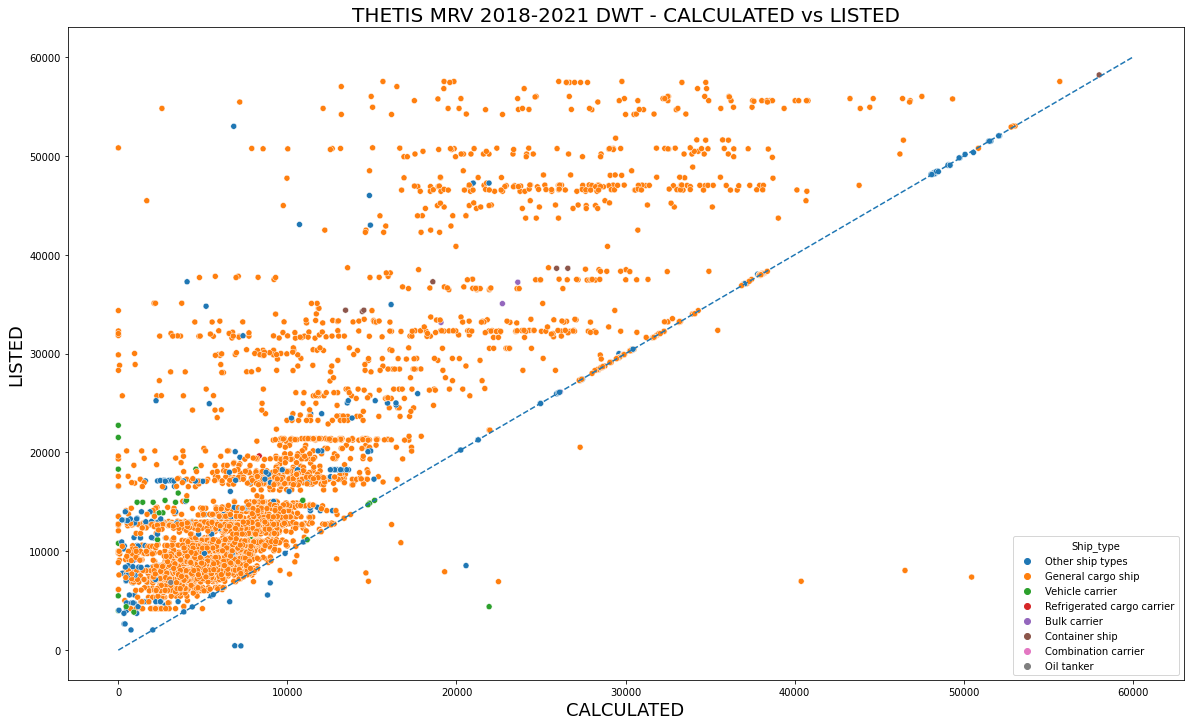

In [360]:
limit = 60000
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 DWT - CALCULATED vs LISTED", fontsize=20)
sns.scatterplot(data = mrv_dwt_df[(mrv_dwt_df.DWT_Calculated < limit) & (mrv_dwt_df.DWT_Listed < limit)],
                 x="DWT_Calculated", y="DWT_Listed", hue="Ship_type")
plt.ylabel("LISTED", fontsize=18)
plt.xlabel("CALCULATED", fontsize=18)
plt.plot([0,limit], [0,limit], linestyle='--')


Text(0.5, 0, 'DWT')

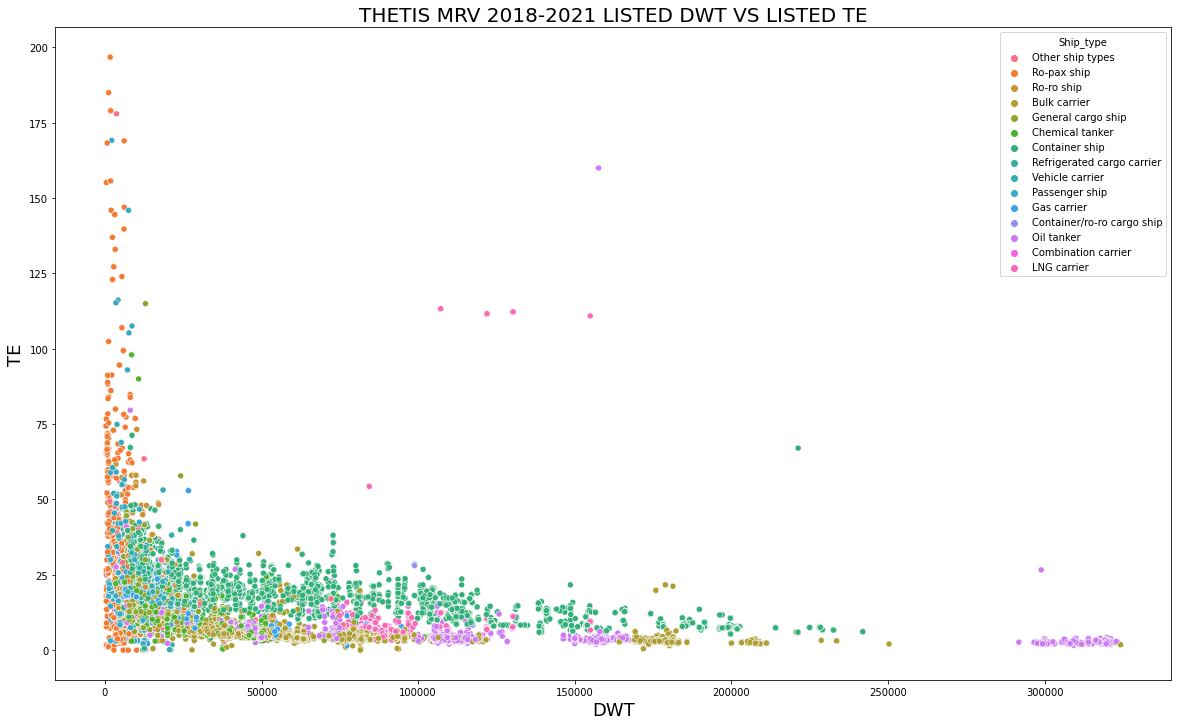

In [362]:
plt.figure(figsize=(20,12))
plt.title("THETIS MRV 2018-2021 LISTED DWT VS LISTED TE", fontsize=20)
sns.scatterplot(data = mrv_dwt_df[mrv_dwt_df.Technical_efficiency < 200],
                 x="DWT_Listed", y="Technical_efficiency", hue="Ship_type")
plt.ylabel("TE", fontsize=18)
plt.xlabel("DWT", fontsize=18)

In [ ]:
fig, axs = plt.subplots(2, 8, figsize=(20, 15))
fig.tight_layout(pad=10)

for x in range(len(Ship_type_change_list)):
    i,j = x//2,x%2
    ax = axs[i,j]
    for
    s = Ship_type_change_list[x].loc[type_order_firstyr.index]
    ax.set_xticklabels(labels=type_order_firstyr.index, rotation=30, ha="right")
    ax.set_xlabel("SHIP TYPE")
    ax.set_ylabel("PERCENTAGE CHANGE")
    ax.set_title(sorted(Ship_type_change_dict.keys())[x])
    sns.barplot(x=s.index, y=s.values, ax=ax)
    ax.legend([],[], frameon=False)
    ax.axhline(y=0, color='k', lw=0.7)
fig.delaxes(axs[1,1])

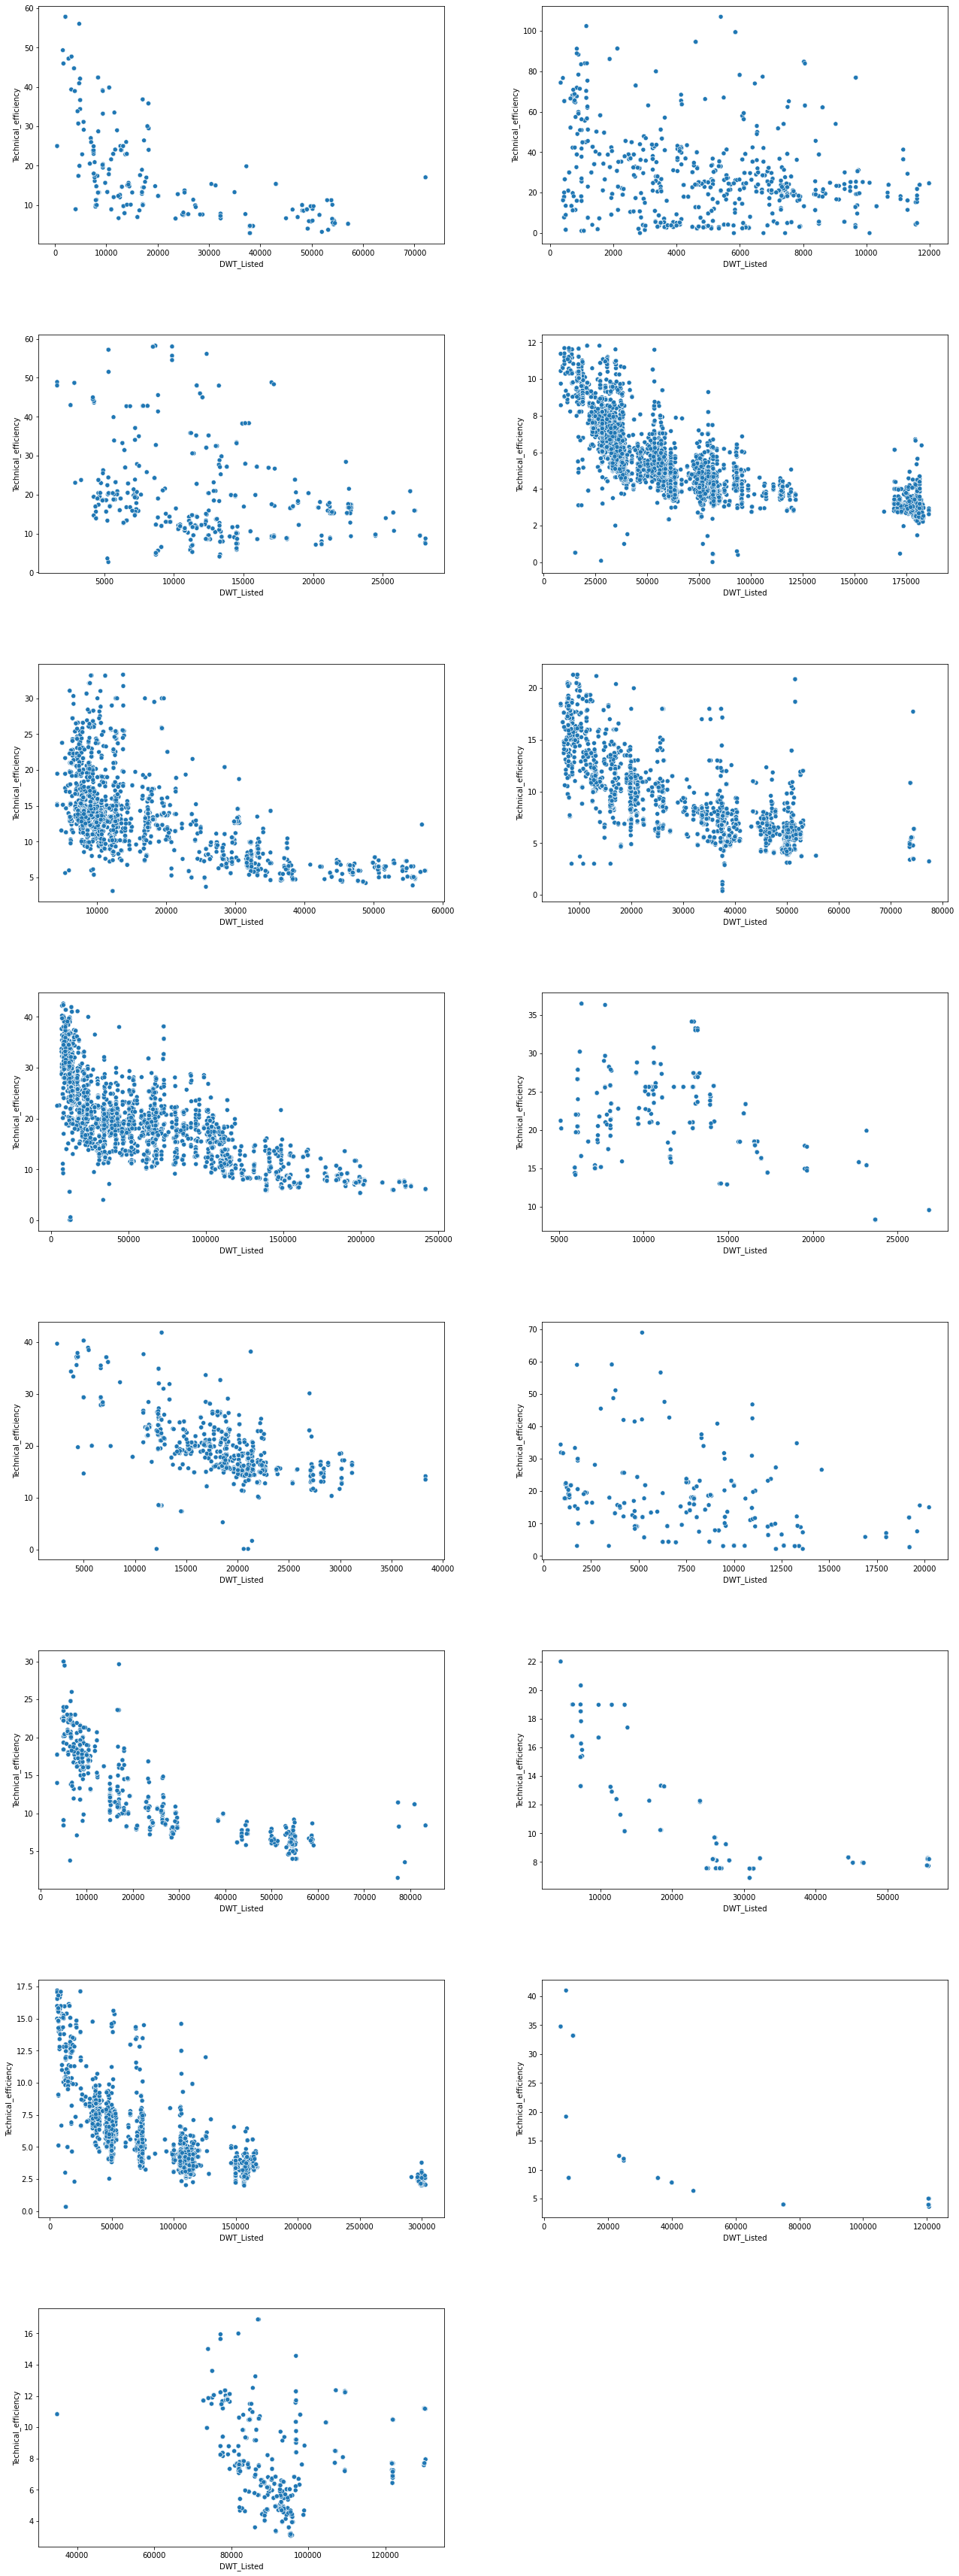

In [383]:
data = mrv_dwt_df[(mrv_dwt_df.Technical_efficiency.notna()) & (mrv_dwt_df.DWT_Listed.notna()) & (mrv_dwt_df.Technical_efficiency < 200)]


fig, axs = plt.subplots(8, 2, figsize=(20, 50))
fig.tight_layout(pad=10)
types = data.Ship_type.unique()
for idx in range(len(types)):
    i,j = idx//2,idx%2
    ax = axs[i,j]
    data_stype = data[data.Ship_type == types[idx]]
    TE_filter = (np.abs(stats.zscore(data_stype.Technical_efficiency)) < 3)
    DWT_filter = (np.abs(stats.zscore(data_stype.DWT_Listed)) < 3)
    data_stype_filtered = data_stype[(TE_filter) & (DWT_filter)]
    sns.scatterplot(data = data_stype_filtered,
                 x="DWT_Listed", y="Technical_efficiency", hue="Ship_type",
                 ax=ax)
    ax.legend([],[], frameon=False)
fig.delaxes(axs[7,1])


In [379]:
data_stype_filtered

IMO_Number         Ship_type  Technical_efficiency  \
0         6703343  Other ship types                 57.84   
1         6703343  Other ship types                 57.84   
2         6703343  Other ship types                 57.84   
24        7310507  Other ship types                 31.13   
25        7310507  Other ship types                 31.13   
...           ...               ...                   ...   
47358     8026907  Other ship types                 15.36   
47359     8130681  Other ship types                  6.66   
47375     8617940  Other ship types                 11.24   
47393     8918942  Other ship types                 11.25   
48073     9425186  Other ship types                  7.62   

       Measured_Efficiency  Fuel_cons_t  Fuel_cons_per_dist_kg/nm  \
0                   210.74       373.50                     70.25   
1                   211.88       225.70                     40.75   
2                   333.51      1607.60                     56.58   
24                  566.60       860.30                     52.60   
25                  286.95       992.10                     47.82   
...                    ...          ...                       ...   
47358               180.53      2551.47                    138.20   
47359                17.04      3309.70                    100.21   
47375                94.11      5218.71                    162.92   
47393                44.87      1908.80                    129.15   
48073                17.33      1334.20                    103.33   

       Fuel_cons_per_dwt_dist_g/dwt.nm  DWT_Calculated  DWT_Listed  
0                                34.46    2.038595e+03        2045  
1                                54.28    7.507369e+02        2045  
2                                 0.32    1.768125e+05        2045  
24                               54.60    9.633700e+02        5579  
25                               72.75    6.573196e+02        5579  
...                                ...             ...         ...  
47358                             4.54    3.044053e+04       30451  
47359                              NaN             NaN       44993  
47375                              NaN             NaN       53818  
47393                              NaN             NaN       53000  
48073                             0.08    1.291625e+06       28261  

[379 rows x 9 columns]

In [364]:
for idx in range(len(types)):
    i,j = idx//2,idx%2
    print(i,j)

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
4 0
4 1
5 0
5 1
6 0
6 1
7 0


In [373]:
(np.abs(stats.zscore(mrv_dwt_df.Technical_efficiency[mrv_dwt_df.Technical_efficiency.notna()])))

0        0.184398
1        0.184398
2        0.184398
4        0.025042
5        0.025042
           ...   
48798    0.029187
48799    0.032665
48800    0.041536
48801    0.032831
48802    0.040127
Name: Technical_efficiency, Length: 44683, dtype: float64

In [372]:
mrv_dwt_df.Technical_efficiency[mrv_dwt_df.Technical_efficiency.notna()]

0        57.84
1        57.84
2        57.84
4        19.40
5        19.40
         ...  
48798    20.40
48799     5.48
48800     3.34
48801     5.44
48802     3.68
Name: Technical_efficiency, Length: 44683, dtype: float64